# DQ project - duplicates & variable for classification

This file is the deliverable for the Data and Information Quality project at Polimi in year 2023

Authors:
- Luca Gerin 10666665
- Claudio Galimberti 10610720


Data quality issues:
- Duplication
- Variable types

ML Task:
- Classification

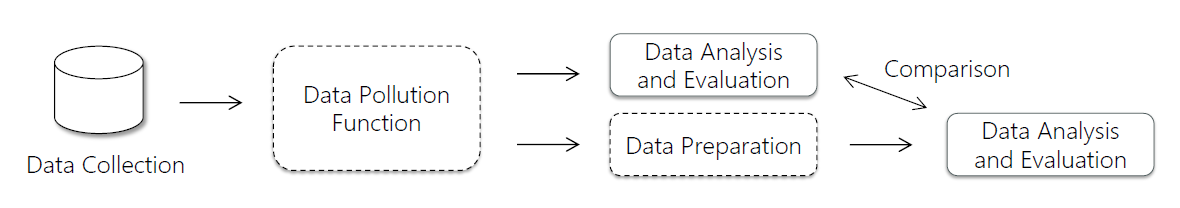

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import recordlinkage

In [2]:
from sklearn.datasets import make_classification
from scripts.D_data_analysis import classification, encoding_categorical_variables
from scripts.E_plot_results import plot

print(sys.path)

['c:\\Users\\Luca\\Documents\\GitHub\\Data_Quality_Project_polimi', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\\python39.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\\lib', 'C:\\Users\\Luca\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0', '', 'C:\\Users\\Luca\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages', 'C:\\Users\\Luca\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\win32', 'C:\\Users\\Luca\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\win32\\lib', 'C:\\Users\\Luca\\AppDat

# Data Creation and Exploration 

In [3]:

# DEFAULT PARAMETERS FOR CLASSIFICATION
#X, y = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)

def make_dataset_for_classification(n_samples, n_features, n_informative, n_redundant, n_repeated, n_classes, n_clusters_per_class, weights, flip_y, class_sep, hypercube, seed):
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant,
                               n_repeated=n_repeated, n_classes=n_classes, n_clusters_per_class=n_clusters_per_class,
                               weights=weights, flip_y=flip_y, class_sep=class_sep, hypercube=hypercube, random_state=seed)
    return X, y


In [4]:
X, y = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)
df = pd.DataFrame(X)


In [5]:
df.columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']  

In [6]:
print(df.head())

   feature_1  feature_2  feature_3  feature_4  feature_5
0  -3.044852   0.401225   1.876653   1.566605  -2.132950
1   1.445783   1.330753   1.140285   0.706253   2.422165
2   2.404213   1.620161  -0.710273  -3.793487   1.183956
3   1.573431  -0.558834   0.359672   0.777892   2.637753
4  -0.849001   2.114740   3.329424  -1.255837  -1.173801


In [7]:
df.shape

(1000, 5)

In [8]:
type(df)

pandas.core.frame.DataFrame

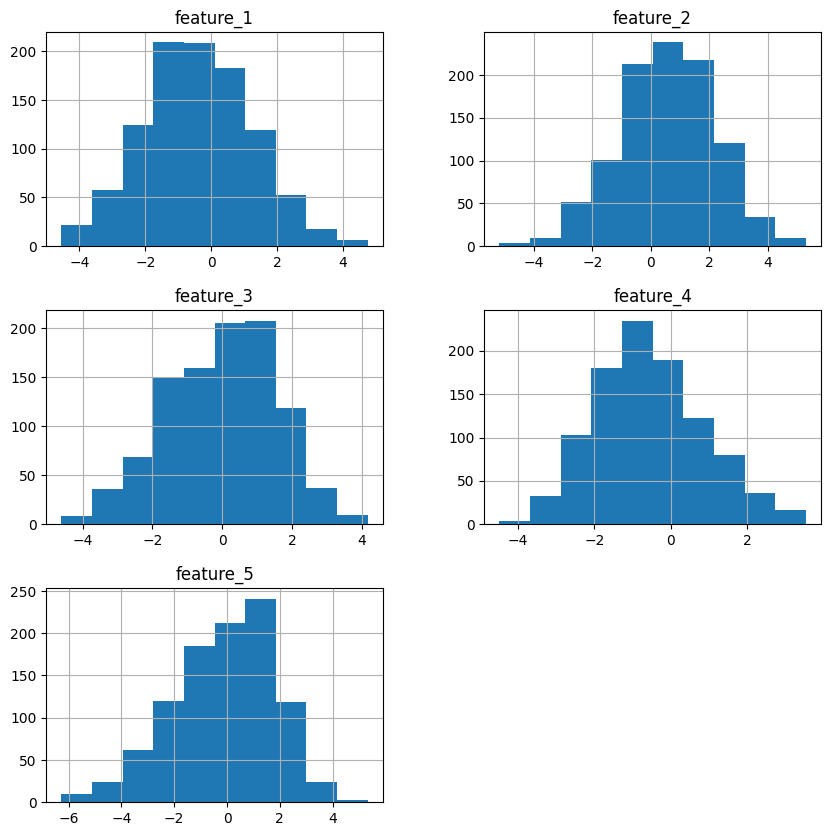

In [9]:
#histogram of distribution of features 
df.hist(figsize=(10,10))
plt.show()


In [10]:
df.dtypes

feature_1    float64
feature_2    float64
feature_3    float64
feature_4    float64
feature_5    float64
dtype: object

In [11]:
num_cells = df.shape[0]*df.shape[1]
print('Number of cells:', num_cells)

Number of cells: 5000


In [12]:
not_null = df.count().sum()
null = df.isnull().sum().sum()
tot = null + not_null
print('Total number of values:', tot)
print('Number of null values:', null)
print('Number of not null values:', not_null)

Total number of values: 5000
Number of null values: 0
Number of not null values: 5000


In [13]:
completeness = not_null / tot
completeness = '{0:.1f}%'.format(completeness*100)
print('Completeness:', completeness)

Completeness: 100.0%


In [14]:
duplicates = df.duplicated()
print('Duplicates: ', duplicates.any())

Duplicates:  False


<Axes: >

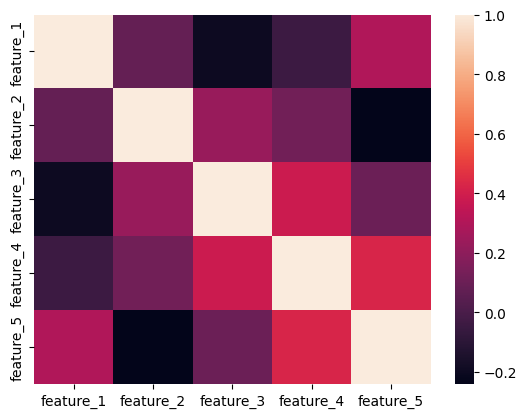

In [15]:
corr = df.corr(method ='spearman',numeric_only=True)
sns.heatmap(corr)

In [16]:
# Creating scatter plots for combinations of columns
def plot_creator(X):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Creating a 2x3 grid of subplots

    for i in range(5):  # Iterate through each column
        row = i // 3  # Determine subplot row
        col = i % 3   # Determine subplot column
        axs[row, col].scatter(X[:, i], X[:, (i + 1) % 5])  # Plot current column against next column 
        axs[row, col].set_xlabel(f'Column {i+1}')
        axs[row, col].set_ylabel(f'Column {(i + 1) % 5 + 1}')

    plt.tight_layout()
    plt.show()

In [17]:
#Creates a mask over the dataset to select randomically the desired percentage of the data to pollute
def mask_creator(percentage):
    mask = np.random.rand(len(df)) < percentage
    return mask

# Duplicates - Pollution Techniques
1) Add random noise to some columns (the number of columns can be decided differentiating through the different datasets)
2) Data scaling and trasformation applying a linear function to the dataset (the function can be decided differentiating through the different datasets)
3) Rounding the data, changing the number of decimals (the number of decimals discarded can be decided differentiating through the different datasets)

At the end the scaling pollution technique was not used because considered very similiar to the noising technique and so was preferred to apply the noising and the rounding to cover all the interesting combination among those techniques


In [18]:
#The function that actually pollutes the data
#It takes as input the datset, the mask used to identify the row to pollute, the number of duplicates to create, 
#the function to use to pollute the data, the parameter of the function (which is specific for each technique used),
#the list of modified columns (which is used to keep track of the columns modified for each row in case they have to be reused/discarded
#for combining techniques), a boolean (combining) to determine if the techniques are combined on DIFFERENT COLUMNS of the same row,
#a boolean (together) to determine if the user wants to pollute the SAME COLUMNS applying different techniques to the same feature,
#and a list of labels to which must be added the labels of the polluted data for the ext classification task

def polluting_data(dataset, mask, duplicates, function, parameter, modified, combining, together, labels):
    polluted_data = []
    #scanning all the rows of the dataset
    for row in range(len(dataset)):
        #The column polluted is only one 
        if(not combining):
            #If the current row has to be duplicated
            if(mask[row]):
                #Different columns are polluted with only one technique
                if(not together):
                    #Deciding randomically which columns to pollute
                    columns = np.random.permutation(5)[:duplicates]
                    modified.append(columns)
                    labels.append(y[row])
                #The rows are being polluted with the second technique so the column must be the same as the one used for the first technique
                else:
                    columns = modified[row]
                    
                pollution(dataset[row], function, parameter, columns, polluted_data)
        #Different columns are polluted with more than one techniques     
        else:
            columns = np.random.permutation(5)[:duplicates]
            #The columns already polluted are discarded to select a column which has not been polluted yet
            while all(elem in modified[row] for elem in columns):
                columns = np.random.permutation(5)[:duplicates]
            modified[row] = np.append(modified[row], columns)
            pollution(dataset[row], function, parameter, columns, polluted_data)
    return polluted_data


def pollution(row, function, parameter, columns, polluted_data):
            new_polluted_row = []
            for value in row:
                if(np.isin(np.where(row == value)[0], columns)):
                    if(function == "round"):
                        new_polluted_row = np.append(new_polluted_row, np.array([np.round(value, decimals=parameter)], dtype='float64'))
                    elif(function == "noise"):
                        new_polluted_row = np.append(new_polluted_row, np.array([value+parameter], dtype='float64'))
                    elif(function == "scale"):
                        new_polluted_row = np.append(new_polluted_row, np.array([value*parameter], dtype='float64'))

                else:
                    new_polluted_row = np.append(new_polluted_row, np.array([value], dtype='float64'))

            polluted_data.append(new_polluted_row)
    



In [19]:
#plot_creator(df.values)

In [20]:
#Example of polluting the data with the noise technique 
#The percentage of the data to pollute is 1.0 to immediately show the corretness of the technique
parameter_noise = np.random.normal(0, 0.1)

modified_noise_try = []
labels_noise_try = []
mask_noise_try = mask_creator(1.0)

noise_array_try = polluting_data(X, mask_noise_try, 2, "noise", parameter_noise, modified_noise_try, False, False, labels_noise_try)
noise_data_try = pd.DataFrame(noise_array_try)

print(df.head())
print(noise_data_try.head())
#plot_creator(noise_data.values)

   feature_1  feature_2  feature_3  feature_4  feature_5
0  -3.044852   0.401225   1.876653   1.566605  -2.132950
1   1.445783   1.330753   1.140285   0.706253   2.422165
2   2.404213   1.620161  -0.710273  -3.793487   1.183956
3   1.573431  -0.558834   0.359672   0.777892   2.637753
4  -0.849001   2.114740   3.329424  -1.255837  -1.173801
          0         1         2         3         4
0 -2.932606  0.513471  1.876653  1.566605 -2.132950
1  1.445783  1.443000  1.140285  0.706253  2.534411
2  2.516460  1.620161 -0.710273 -3.793487  1.296202
3  1.573431 -0.446588  0.359672  0.777892  2.749999
4 -0.849001  2.226986  3.329424 -1.255837 -1.061555


In [21]:
#Example of polluting the data with the scale technique

parameter_round = np.random.randint(2, 4)

modified_round_try = []
labels_round_try = []
mask_round_try = mask_creator(1.0)

round_array_try = polluting_data(X, mask_round_try, 2, "round", parameter_round, modified_round_try, False, False, labels_round_try)
round_data_try = pd.DataFrame(round_array_try)

print(df.head())
print(round_data_try.head())
#plot_creator(scale_data.values)

   feature_1  feature_2  feature_3  feature_4  feature_5
0  -3.044852   0.401225   1.876653   1.566605  -2.132950
1   1.445783   1.330753   1.140285   0.706253   2.422165
2   2.404213   1.620161  -0.710273  -3.793487   1.183956
3   1.573431  -0.558834   0.359672   0.777892   2.637753
4  -0.849001   2.114740   3.329424  -1.255837  -1.173801
          0         1         2         3         4
0 -3.040000  0.401225  1.876653  1.570000 -2.132950
1  1.445783  1.330753  1.140000  0.710000  2.422165
2  2.404213  1.620000 -0.710000 -3.793487  1.183956
3  1.570000 -0.560000  0.359672  0.777892  2.637753
4 -0.849001  2.114740  3.330000 -1.260000 -1.173801


In [22]:
#Example of polluting different columns of the same row with different techniques

parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

modified_combining_try = []
labels_combining_try = []
mask_combining_try = mask_creator(1.0)

noise_array_combining_try = polluting_data(X, mask_combining_try, 2, "noise", parameter_noise, modified_combining_try, False, False, labels_combining_try)

combining_array = polluting_data(noise_array_combining_try, mask_combining_try, 1, "round", parameter_round, modified_combining_try, True, False, labels_combining_try)
combining_data = pd.DataFrame(combining_array)
print(df.head())
print(combining_data.head())

#plot_creator(noise_round_data.values)

   feature_1  feature_2  feature_3  feature_4  feature_5
0  -3.044852   0.401225   1.876653   1.566605  -2.132950
1   1.445783   1.330753   1.140285   0.706253   2.422165
2   2.404213   1.620161  -0.710273  -3.793487   1.183956
3   1.573431  -0.558834   0.359672   0.777892   2.637753
4  -0.849001   2.114740   3.329424  -1.255837  -1.173801
          0         1         2         3         4
0 -3.044852  0.352711  1.876653  1.518091 -2.130000
1  1.397269  1.330000  1.140285  0.706253  2.373651
2  2.355699  1.571647 -0.710273 -3.793487  1.180000
3  1.524917 -0.560000  0.359672  0.729378  2.637753
4 -0.897515  2.114740  3.329424 -1.260000 -1.222315


In [23]:
#Example of polluting the same columns of the same row with different techniques

parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

modified_together_try = []
labels_together_try = []
mask_together_try = mask_creator(1.0)

noise_array_together_try = polluting_data(X, mask_together_try, 2, "noise", parameter_noise, modified_together_try, False, False, labels_together_try)

mask_all_ones_try = np.ones(len(noise_array_together_try), dtype=bool)

together_array_try = polluting_data(noise_array_together_try, mask_all_ones_try, 2, "round", parameter_round, modified_together_try, False, True, labels_together_try)
together_data_try = pd.DataFrame(together_array_try)

print(df.head())
print(together_data_try.head())

   feature_1  feature_2  feature_3  feature_4  feature_5
0  -3.044852   0.401225   1.876653   1.566605  -2.132950
1   1.445783   1.330753   1.140285   0.706253   2.422165
2   2.404213   1.620161  -0.710273  -3.793487   1.183956
3   1.573431  -0.558834   0.359672   0.777892   2.637753
4  -0.849001   2.114740   3.329424  -1.255837  -1.173801
          0         1         2         3         4
0 -2.970000  0.480000  1.876653  1.566605 -2.132950
1  1.520000  1.410000  1.140285  0.706253  2.422165
2  2.404213  1.620161 -0.630000 -3.720000  1.183956
3  1.650000 -0.558834  0.359672  0.777892  2.710000
4 -0.849001  2.114740  3.329424 -1.180000 -1.100000


# Duplicates - Data pollution with 10 different techniques 
1) Noising 1 column 
2) Rounding 1 column 
3) Noising 2 columns of the same row 
4) Rounding 2 columns of the same row 
5) Noising 1 column, rounding a different column of the same row
6) Noising and rounding applied together to 2 columns of the same row 
7) Noising 3 different columns of the same row
8) Rounding 3 different columns of the same row 
9) Noising 2 columns, rounding 1 different column of the same row 
10) Noising 1 column, rounding 2 different columns of the same row

In [24]:
#1) Noising 1 column

datasets_noise_one = [] #Array that contains the 10 dataset polluted with noise on 1 column with different percentages of duplicates
labels_noise_one = [] #Array that contains the labels of the duplicated datasets 
parameter = np.random.normal(0, 0.1)

for i in range(10):
    
    modified_noise = [] #Array that contains the columns modified for each row of the current dataset
    labels_noise_one_array = [] #Array that contains the labels of the current dataset
    mask_noise = mask_creator(0.05*(i+1)) #Mask used to select the rows to pollute which increaments by 5% each iteration
    
    noise_array = polluting_data(X, mask_noise, 1, "noise", parameter, modified_noise, False, False, labels_noise_one_array)
    noise_data = pd.DataFrame(noise_array)

    datasets_noise_one.append(noise_data.values)
    labels_noise_one.append(labels_noise_one_array)

In [25]:
#2) Rounding 1 column 

datasets_round_one = []
labels_round_one = []
parameter = np.random.randint(2, 4)

for i in range(10): 

    modified_round = []
    labels_round_one_array = []
    mask_round = mask_creator(0.05*(i+1))
    
    round_array = polluting_data(X, mask_round, 1, "round", parameter, modified_round, False, False, labels_round_one_array)
    round_data = pd.DataFrame(round_array)

    datasets_round_one.append(round_data.values)
    labels_round_one.append(labels_round_one_array)

In [26]:
#3) Noising 2 columns of the same row

datasets_noise_two = []
labels_noise_two = []
parameter = np.random.normal(0, 0.1)

for i in range(10):
    
    modified_noise_two = []
    labels_noise_two_array = []
    mask_noise_two = mask_creator(0.05*(i+1))
    
    noise_array_two = polluting_data(X, mask_noise_two, 2, "noise", parameter, modified_noise_two, False, False, labels_noise_two_array)
    noise_data_two = pd.DataFrame(noise_array_two)

    datasets_noise_two.append(noise_data_two.values)
    labels_noise_two.append(labels_noise_two_array)

In [27]:
#4) Rounding 2 columns of the same row

datasets_round_two = []
labels_round_two = []
parameter = np.random.randint(2, 4)

for i in range(10):
    
    modified_round_two = []
    labels_round_two_array = []
    mask_round_two = mask_creator(0.05*(i+1))
    
    round_array_two = polluting_data(X, mask_round_two, 2, "round", parameter, modified_round_two, False, False, labels_round_two_array)
    round_data_two = pd.DataFrame(round_array_two)

    datasets_round_two.append(round_data_two.values)
    labels_round_two.append(labels_round_two_array)

In [28]:
#5) Noising 1 column, rounding a different column of the same row

datasets_noise_round_one = []
labels_noise_round_one = []
parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

for i in range(10):
    
    modified_noise_round_one = []
    labels_noise_round_one_array = []
    mask_noise_round_one = mask_creator(0.05*(i+1))

    #In this case the two techniques are combined on different columns of the same row, so the first pollution is applied to the whole dataset
    #and then the second one is applied to the already polluted dataset using the Modified_noise_round_one array to keep track of the columns already 
    #polluted
    #In the second pollution is not important the mask because in the polluting_data function in this case the mask is not used, the pollution 
    #is applied to all the rows of the input dataset
    
    noise_round_array_one = polluting_data(X, mask_noise_round_one, 1, "noise", parameter_noise, modified_noise_round_one, False, False, labels_noise_round_one_array)
    noise_round_array_one = polluting_data(noise_round_array_one, mask_noise_round_one, 1, "round", parameter_round, modified_noise_round_one, True, False, labels_noise_round_one_array)
    noise_round_data_one = pd.DataFrame(noise_round_array_one)

    datasets_noise_round_one.append(noise_round_data_one.values)
    labels_noise_round_one.append(labels_noise_round_one_array)  
    

In [29]:
#6) Noising and rounding applied together to 2 columns of the same row 

datasets_round_noise_together = []
labels_noise_round_together = []
parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

for i in range(10):
    
    modified_noise_round_together = []
    labels_noise_round_together_array = []
    mask_noise_round_together = mask_creator(0.05*(i+1))
    
    #In this case the two techniques are combined on the same columns of the same row, so the first pollution is applied to the whole dataset
    #and then the second one is applied to the already polluted dataset using the Modified_noise_round_together array to keep track of the columns 
    #already polluted in order to apply to them the second technique
    #In the second pollution is necessary to use a mask with all ones in order to apply the pollution to all the input dataset because in this case
    #the polluting_data function enters the branch in which is considered the mask to select the rows to be polluted
    
    noise_round_array_together = polluting_data(X, mask_noise_round_together, 2, "noise", parameter_noise, modified_noise_round_together, False, False, labels_noise_round_together_array)
    
    mask_all_ones = np.ones(len(noise_round_array_together), dtype=bool)

    noise_round_array_together = polluting_data(noise_round_array_together, mask_all_ones, 2, "round", parameter_round, modified_noise_round_together, False, True, labels_noise_round_together_array)
    noise_round_data_together = pd.DataFrame(noise_round_array_together)

    datasets_round_noise_together.append(noise_round_data_together.values)
    labels_noise_round_together.append(labels_noise_round_together_array)
    
    

In [30]:
#7) Noising 3 different columns of the same row

datasets_noise_three = []
labels_noise_three = []
parameter = np.random.normal(0, 0.1)

for i in range(10):
    
    modified_noise_three = []
    labels_noise_three_array = []
    mask_noise_three = mask_creator(0.05*(i+1))
    
    noise_array_three = polluting_data(X, mask_noise_three, 3, "noise", parameter, modified_noise_three, False, False, labels_noise_three_array)
    noise_data_three = pd.DataFrame(noise_array_three)

    datasets_noise_three.append(noise_data_three.values)
    labels_noise_three.append(labels_noise_three_array)


In [31]:
#8) Rounding 3 different columns of the same row

datasets_round_three = []
labels_round_three = []
parameter = np.random.randint(2, 4)

for i in range(10):
    
    modified_round_three = []
    labels_round_three_array = []
    mask_round_three = mask_creator(0.05*(i+1))
    
    round_array_three = polluting_data(X, mask_round_three, 3, "round", parameter, modified_round_three, False, False, labels_round_three_array)
    round_data_three = pd.DataFrame(round_array_three)

    datasets_round_three.append(round_data_three.values)
    labels_round_three.append(labels_round_three_array)


In [32]:
#9) Noising 2 columns, rounding a different column of the same row

datasets_noise_round_two_one = []
labels_noise_round_two_one = []
parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

for i in range(10):
    
    modified_noise_round_two_one = []
    labels_noise_round_two_one_array = []
    mask_noise_round_two_one = mask_creator(0.05*(i+1))

    #Same case as the one in which noise and round are applied to to different columns but in this case the noising is applied to 2 columns
    #and the rounding to 1 column obtaining a combination that involves 3 different columns

    noise_round_array_two_one = polluting_data(X, mask_noise_round_two_one, 2, "noise", parameter_noise, modified_noise_round_two_one, False, False, labels_noise_round_two_one_array)
    noise_round_array_two_one = polluting_data(noise_round_array_two_one, mask_noise_round_two_one, 1, "round", parameter_round, modified_noise_round_two_one, True, False, labels_noise_round_two_one_array)
    noise_round_data_two_one = pd.DataFrame(noise_round_array_two_one)

    datasets_noise_round_two_one.append(noise_round_data_two_one.values)
    labels_noise_round_two_one.append(labels_noise_round_two_one_array)
    

In [33]:
#10) Noising 1 column, rounding 2 different columns of the same row

datasets_noise_round_one_two = []
labels_noise_round_one_two = []
parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

for i in range(10):
    
    modified_noise_round_one_two = []
    labels_noise_round_one_two_array = []
    mask_noise_round_one_two = mask_creator(0.05*(i+1))
    
    #Same case as the one in which noise and round are applied to 2 different columns but in this case the noising is applied to 1 column
    #and the rounding to 2 columns obtaining a combination that involves 3 different columns

    noise_round_array_one_two = polluting_data(X, mask_noise_round_one_two, 1, "noise", parameter_noise, modified_noise_round_one_two, False, False, labels_noise_round_one_two_array)
    noise_round_array_one_two = polluting_data(noise_round_array_one_two, mask_noise_round_one_two, 2, "round", parameter_round, modified_noise_round_one_two, True, False, labels_noise_round_one_two_array)
    noise_round_data_one_two = pd.DataFrame(noise_round_array_one_two)

    datasets_noise_round_one_two.append(noise_round_data_one_two.values)
    labels_noise_round_one_two.append(labels_noise_round_one_two_array)
    

In [34]:
#This function is used to spread the duplicates into the original dataset without changing the order of the rows
#It takes as input the duplicates and the relatives labels and returns the final polluted dataset and labels 

def duplicates_spreader(duplicates, labels):
    final_polluted_dataset = X
    final_polluted_labels = y

    for i in range(len(duplicates)):
        randomic_index = np.random.randint(0, len(final_polluted_dataset))
        final_polluted_dataset = np.insert(final_polluted_dataset, randomic_index, duplicates[i], axis=0)
        final_polluted_labels = np.insert(final_polluted_labels, randomic_index, labels[i], axis=0)
    return final_polluted_dataset, final_polluted_labels
        

In [35]:
#Applying the duplicates_spreader function to all the datasets polluted with the same technique obtaining the final polluted datasets and labels
#which conists of the original dataset with the duplicates spreaded into it.
#The procedure involves a for cycle because must be applied to all the datasets polluted with the same combination pf techniques but having 
#different percentages of duplicates

final_datasets_noise_one = []
final_labels_noise_one = []
final_datasets_round_one = []
final_labels_round_one = []
final_datasets_noise_two = []
final_labels_noise_two = []
final_datasets_round_two = []
final_labels_round_two = []
final_datasets_noise_round_one = []
final_labels_noise_round_one = []
final_datasets_round_noise_together = []
final_labels_noise_round_together = []
final_datasets_noise_three = []
final_labels_noise_three = []
final_datasets_round_three = []
final_labels_round_three = []
final_datasets_noise_round_two_one = []
final_labels_noise_round_two_one = []
final_datasets_noise_round_one_two = []
final_labels_noise_round_one_two = []


for i in range(10):
    dataset, label = duplicates_spreader(datasets_noise_one[i], labels_noise_one[i])
    final_datasets_noise_one.append(dataset)
    final_labels_noise_one.append(label)

    dataset, label = duplicates_spreader(datasets_round_one[i], labels_round_one[i])
    final_datasets_round_one.append(dataset)
    final_labels_round_one.append(label)

    dataset, label = duplicates_spreader(datasets_noise_two[i], labels_noise_two[i])
    final_datasets_noise_two.append(dataset)
    final_labels_noise_two.append(label)

    dataset, label = duplicates_spreader(datasets_round_two[i], labels_round_two[i])
    final_datasets_round_two.append(dataset)
    final_labels_round_two.append(label)

    dataset, label = duplicates_spreader(datasets_noise_round_one[i], labels_noise_round_one[i])
    final_datasets_noise_round_one.append(dataset)
    final_labels_noise_round_one.append(label)

    dataset, label = duplicates_spreader(datasets_round_noise_together[i], labels_noise_round_together[i])
    final_datasets_round_noise_together.append(dataset)
    final_labels_noise_round_together.append(label)

    dataset, label = duplicates_spreader(datasets_noise_three[i], labels_noise_three[i])
    final_datasets_noise_three.append(dataset)
    final_labels_noise_three.append(label)

    dataset, label = duplicates_spreader(datasets_round_three[i], labels_round_three[i])
    final_datasets_round_three.append(dataset)
    final_labels_round_three.append(label)

    dataset, label = duplicates_spreader(datasets_noise_round_two_one[i], labels_noise_round_two_one[i])
    final_datasets_noise_round_two_one.append(dataset)
    final_labels_noise_round_two_one.append(label)

    dataset, label = duplicates_spreader(datasets_noise_round_one_two[i], labels_noise_round_one_two[i])
    final_datasets_noise_round_one_two.append(dataset)
    final_labels_noise_round_one_two.append(label)
    
    


# Duplicates - Data Analysis and Evaluation 

In [36]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree","LogisticRegression","KNN","RandomForest","AdaBoost","MLP"]
SEED = 2023

def classifier_function(dataset, labels, title1, title2, title3):
    results_for_each_algorithm = []
    for algorithm in CLASSIFICATION_ALGORITHMS: 

        results_single_algorithm = []

        #Iterating for each dataset polluted with the same combination of techniques having different percentages of duplicates
        for i in range(0, 10): 
            
            X = dataset[i]
            y = labels[i]

            results_1_analysis = classification(X, y, algorithm, SEED)
            results_single_algorithm.append(results_1_analysis)

        results_for_each_algorithm.append(results_single_algorithm)

    plot(x_axis_values=[5,10,15,20,25,30,35,40,45,50], x_label="Percentage of duplicates", results=results_for_each_algorithm, title=title1, algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
    plot(x_axis_values=[5,10,15,20,25,30,35,40,45,50], x_label="Percentage of duplicates", results=results_for_each_algorithm, title=title2, algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
    plot(x_axis_values=[5,10,15,20,25,30,35,40,45,50], x_label="Percentage of duplicates", results=results_for_each_algorithm, title=title3, algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

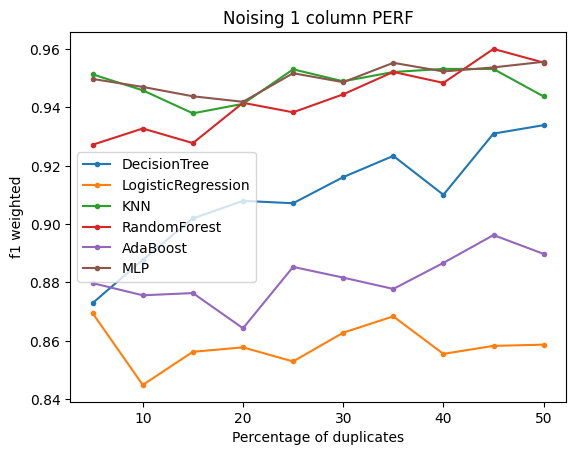

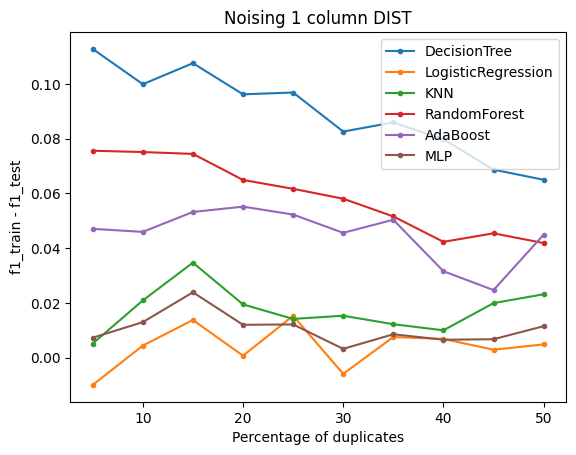

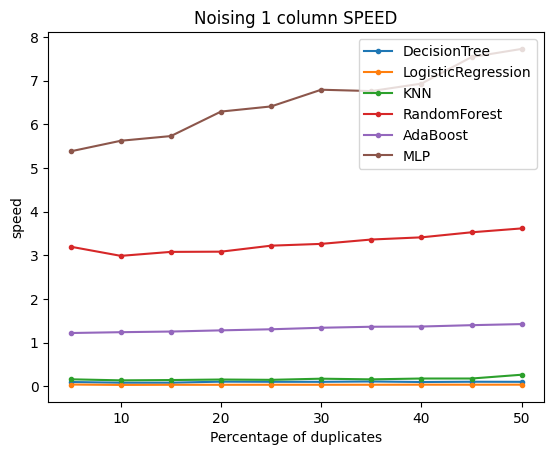

In [37]:
classifier_function(final_datasets_noise_one, final_labels_noise_one, "Noising 1 column PERF", "Noising 1 column DIST", "Noising 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

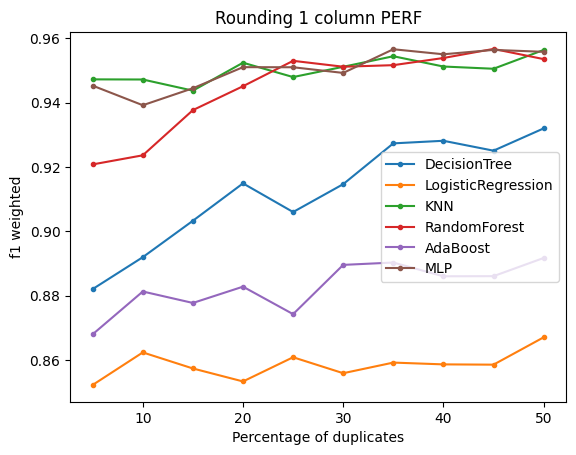

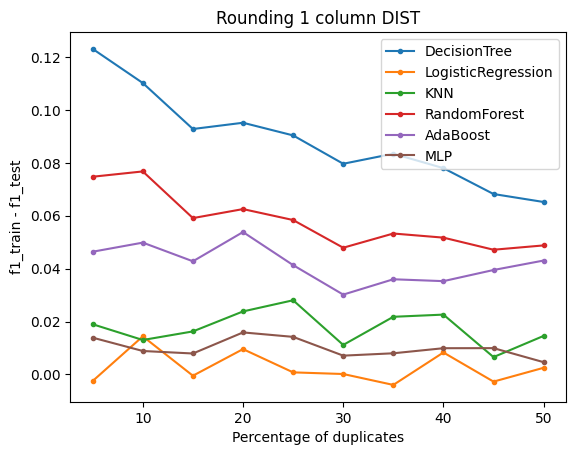

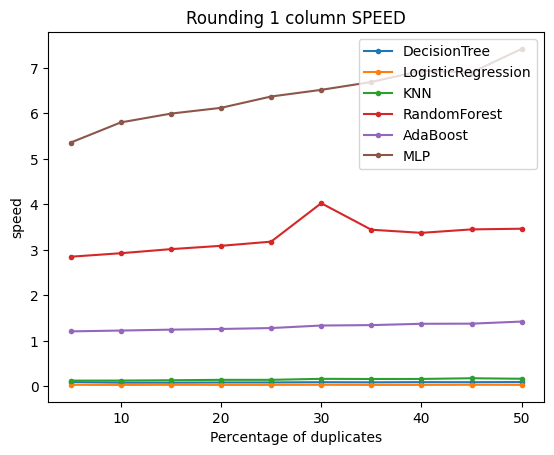

In [38]:
classifier_function(final_datasets_round_one, final_labels_round_one, "Rounding 1 column PERF", "Rounding 1 column DIST", "Rounding 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

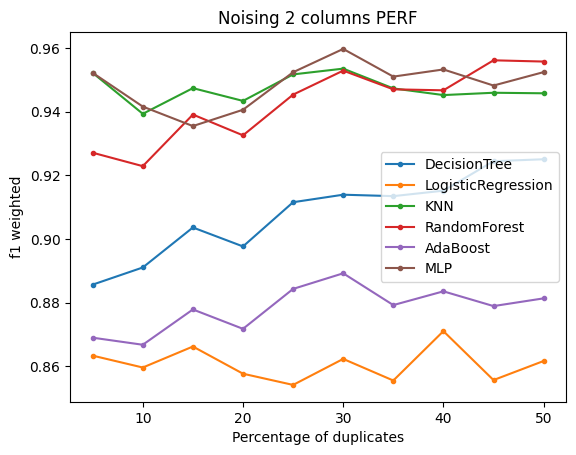

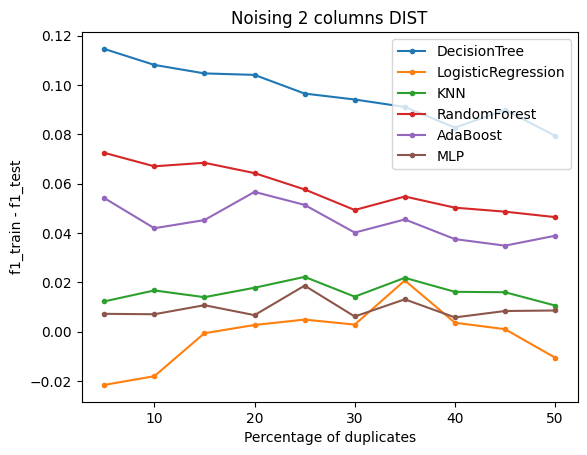

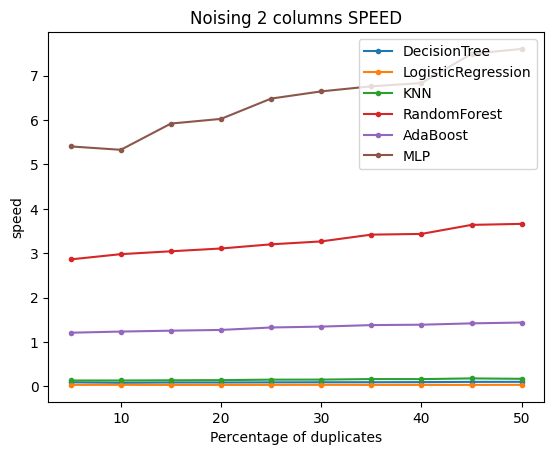

In [39]:
classifier_function(final_datasets_noise_two, final_labels_noise_two, "Noising 2 columns PERF", "Noising 2 columns DIST", "Noising 2 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

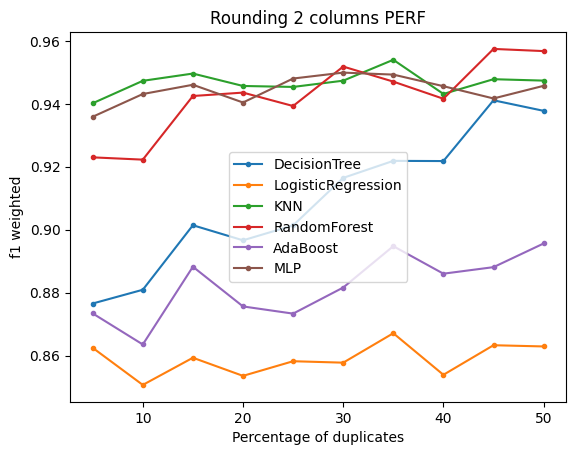

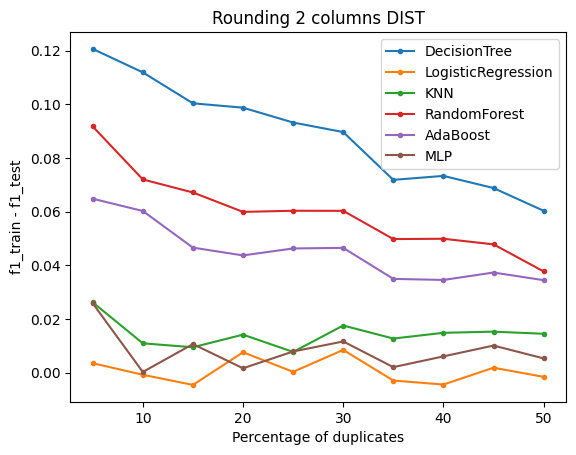

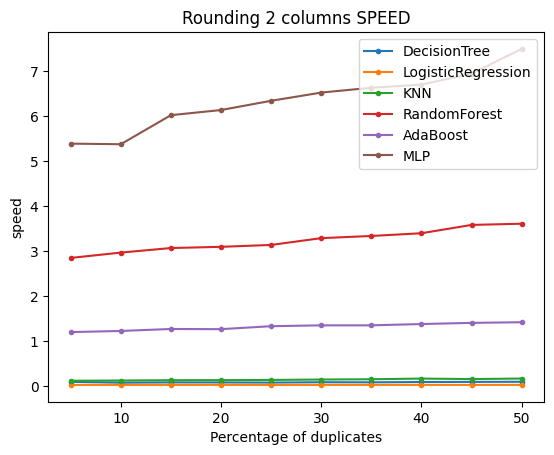

In [40]:
classifier_function(final_datasets_round_two, final_labels_round_two, "Rounding 2 columns PERF", "Rounding 2 columns DIST", "Rounding 2 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

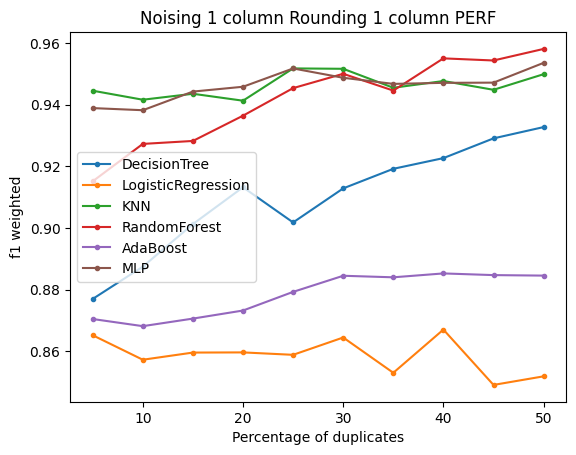

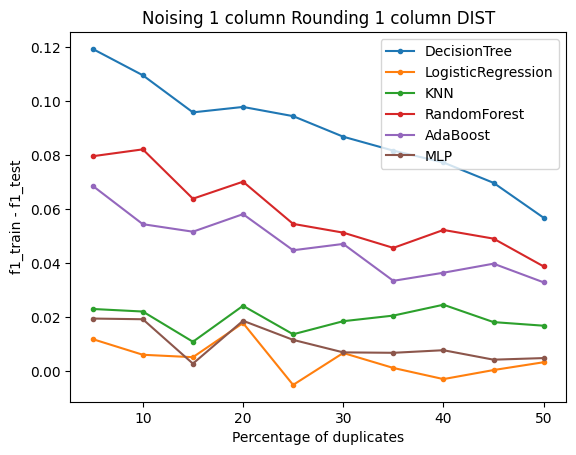

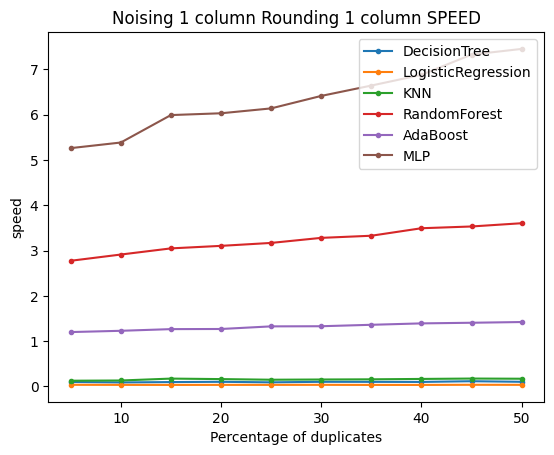

In [41]:
classifier_function(final_datasets_noise_round_one, final_labels_noise_round_one, "Noising 1 column Rounding 1 column PERF", "Noising 1 column Rounding 1 column DIST", "Noising 1 column Rounding 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

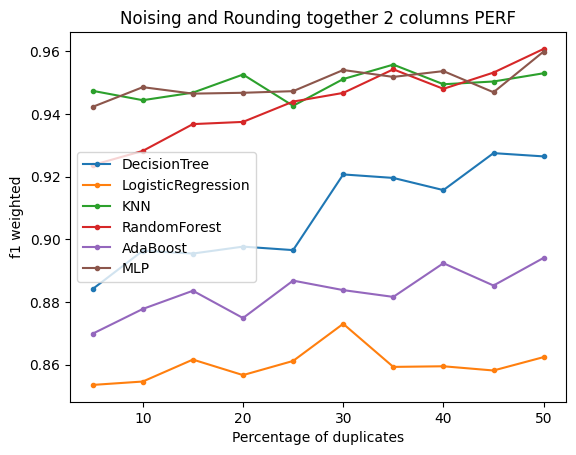

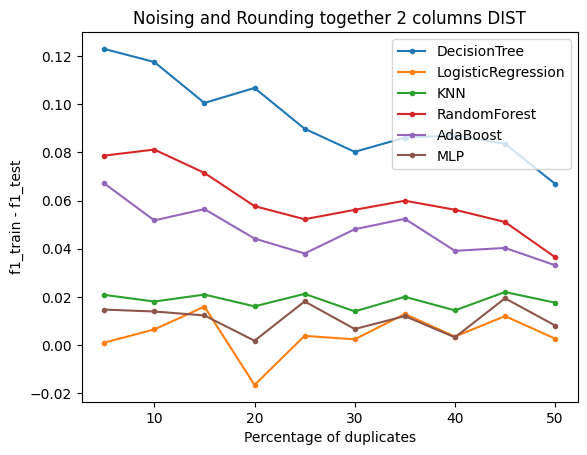

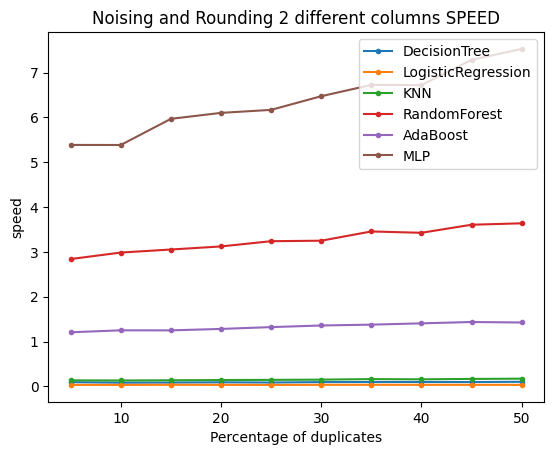

In [42]:
classifier_function(final_datasets_round_noise_together, final_labels_noise_round_together, "Noising and Rounding together 2 columns PERF", "Noising and Rounding together 2 columns DIST", "Noising and Rounding 2 different columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

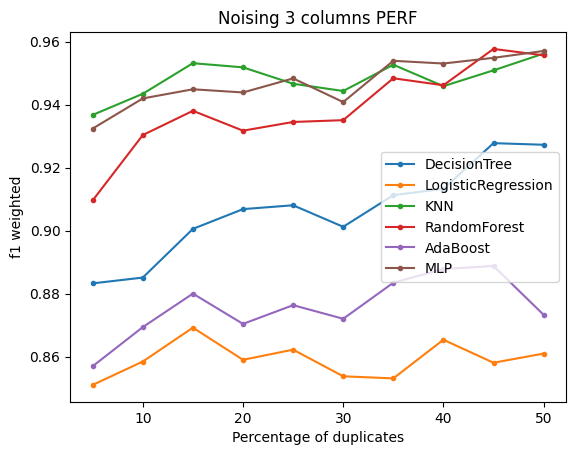

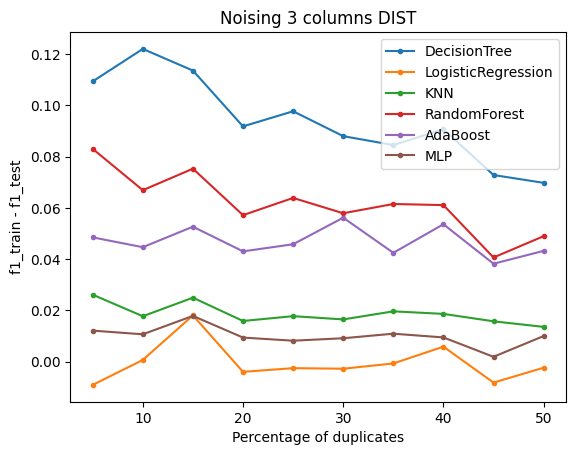

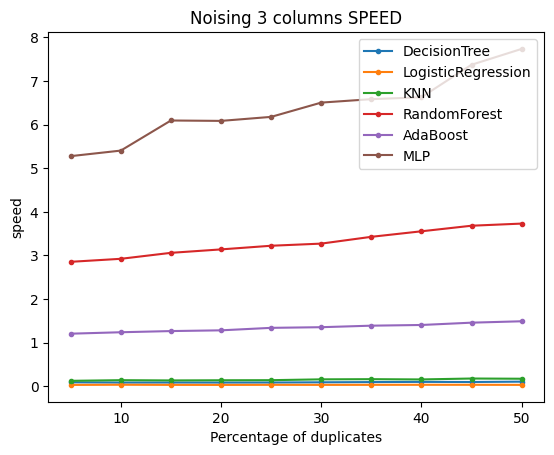

In [43]:
classifier_function(final_datasets_noise_three, final_labels_noise_three, "Noising 3 columns PERF", "Noising 3 columns DIST", "Noising 3 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

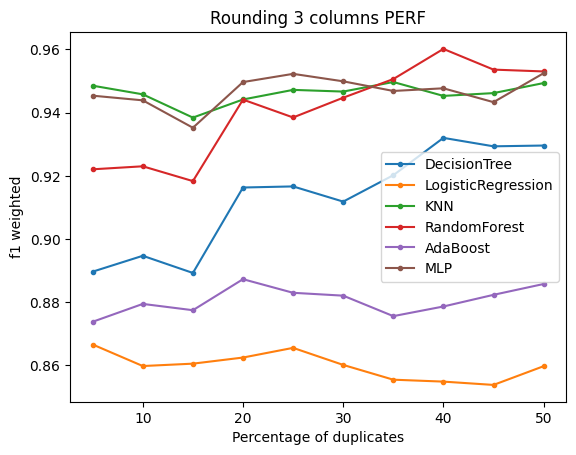

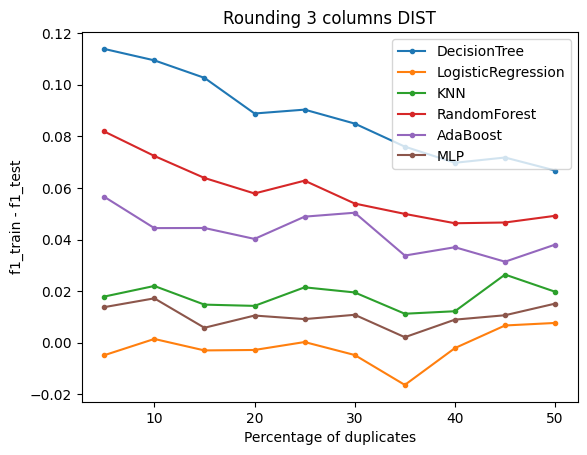

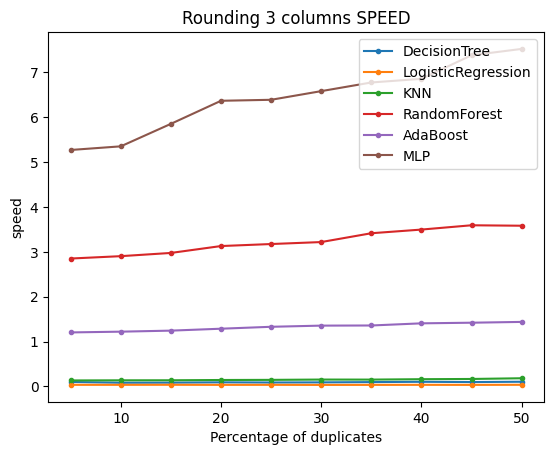

In [44]:
classifier_function(final_datasets_round_three, final_labels_round_three, "Rounding 3 columns PERF", "Rounding 3 columns DIST", "Rounding 3 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

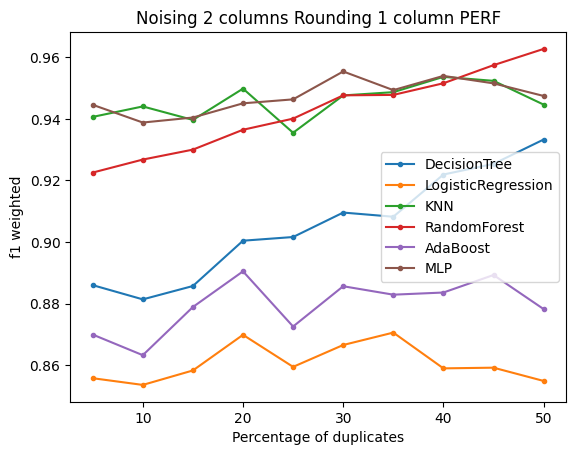

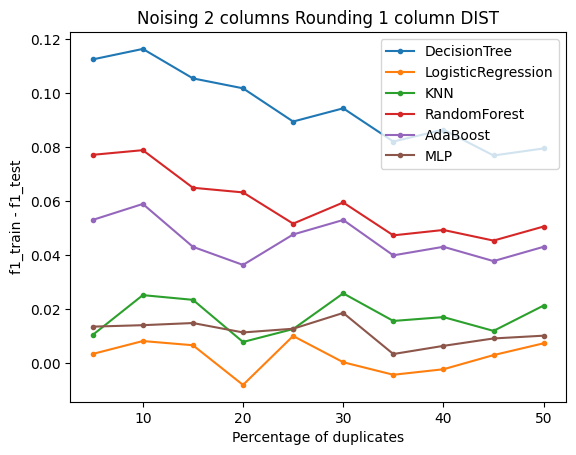

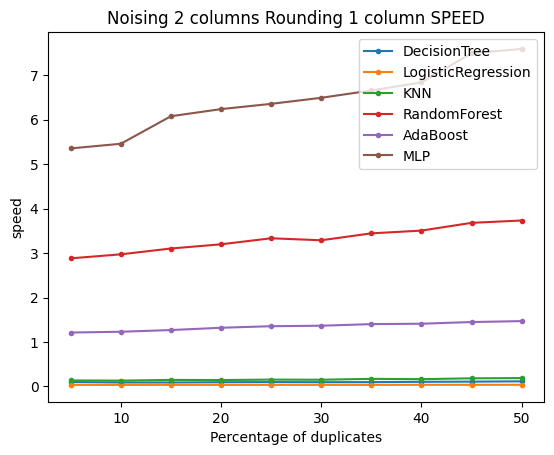

In [45]:
classifier_function(final_datasets_noise_round_two_one, final_labels_noise_round_two_one, "Noising 2 columns Rounding 1 column PERF", "Noising 2 columns Rounding 1 column DIST", "Noising 2 columns Rounding 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

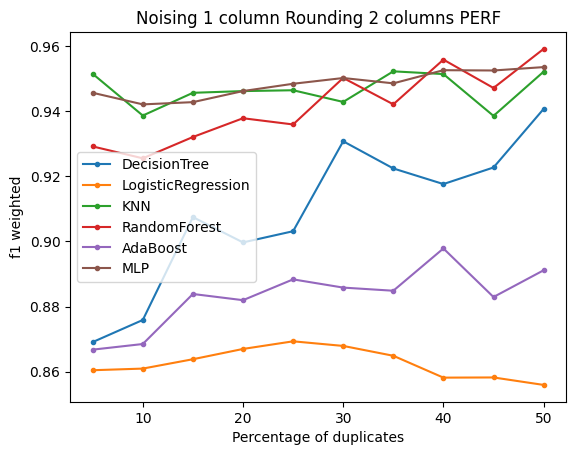

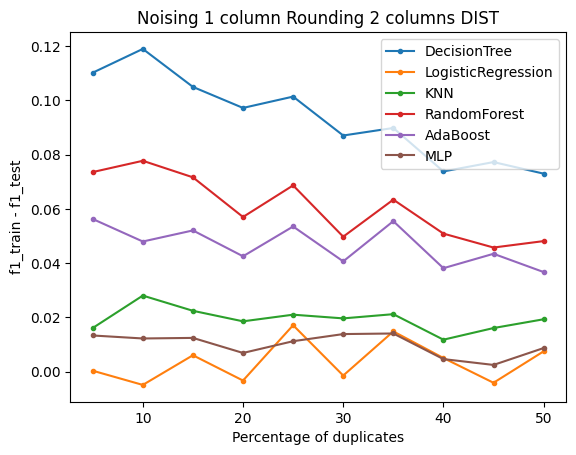

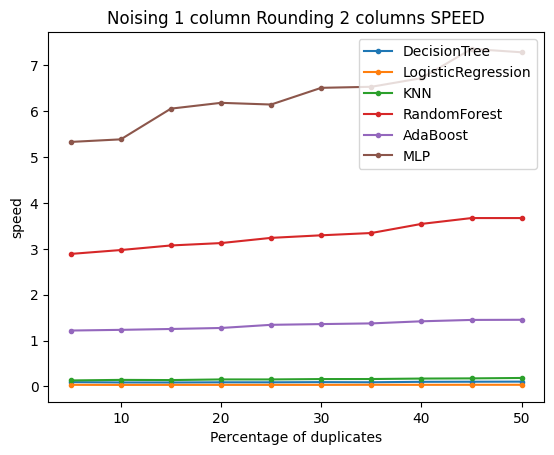

In [46]:
classifier_function(final_datasets_noise_round_one_two, final_labels_noise_round_one_two, "Noising 1 column Rounding 2 columns PERF", "Noising 1 column Rounding 2 columns DIST", "Noising 1 column Rounding 2 columns SPEED")

# Duplicates - Data Cleaning 

Use this dataset as example:

In [47]:
import warnings
warnings.filterwarnings('ignore')

Function to check for exact matching tuples and remove them, taking into account to accordingly modify the labels data:

In [48]:
#remove exact duplicates and the corresponding labels
def drop_exact(df, labels):
    if(df.duplicated().any()):
        df.drop_duplicates(inplace=True)
        labels.drop(df[df.duplicated()].index, inplace=True)
        return df, labels

Function to find the non-exact matches of tuples that are duplicates:

In [49]:
def find_matches(df):
    #if the columns name are not the desired, rename columns
    if(df.columns[0] != 'feature_0' or df.columns[1] != 'feature_1' or df.columns[2] != 'feature_2' or df.columns[3] != 'feature_3' or df.columns[4] != 'feature_4'):
        df.rename(columns={0:'feature_0'}, inplace=True)
        df.rename(columns={1:'feature_1'}, inplace=True)
        df.rename(columns={2:'feature_2'}, inplace=True)
        df.rename(columns={3:'feature_3'}, inplace=True)
        df.rename(columns={4:'feature_4'}, inplace=True)
    
    #find the candidate links using sorted neighbourhood
    indexer1 = recordlinkage.index.SortedNeighbourhood(
        left_on='feature_2', window=91
    )
    candidate_links = indexer1.index(df)

    #define rules to compare the candidate links: the rows are compared feature per feature, to find possible pairs of rows that match
    compare_c = recordlinkage.Compare()
    compare_c.numeric('feature_0','feature_0', method='gauss', offset=0.1, scale=0.1, origin=0.0, label='feature_0')
    compare_c.numeric('feature_1','feature_1', method='gauss', offset=0.1, scale=0.1, origin=0.0, label='feature_1')
    compare_c.numeric('feature_2','feature_2', method='gauss', offset=0.1, scale=0.1, origin=0.0, label='feature_2')
    compare_c.numeric('feature_3','feature_3', method='gauss', offset=0.1, scale=0.1, origin=0.0, label='feature_3')
    compare_c.numeric('feature_4','feature_4', method='gauss', offset=0.1, scale=0.1, origin=0.0, label='feature_4')

    #compute the features
    features = compare_c.compute(candidate_links, df)

    #find the matches: the couples of rows that have the maximum number of features with a score of 1, are considered duplicated
    max_score = max(features.sum(axis=1))
    matches = features[features.sum(axis=1) >= max_score]

    return matches

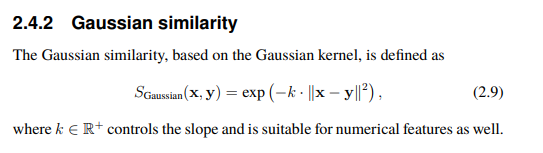

*numeric()* is abbrevaition for:

classrecordlinkage.compare.Numeric(left_on, right_on, method='linear', offset=0.0, scale=1.0, origin=0.0, missing_value=0.0, label=None)

In case of agreement, the similarity is 1 and in case of complete disagreement it is 0.

Parameters:
- left_on (str or int) – The name or position of the column in the left DataFrame.
- right_on (str or int) – The name or position of the column in the right DataFrame.
- method (float) – The metric used. Options ‘step’, ‘linear’, ‘exp’, ‘gauss’ or ‘squared’. Default ‘linear’.
- offset (float) – The offset. See image above.
- scale (float) – The scale of the numeric comparison method. See the image above. This argument is not available for the ‘step’ algorithm. The rate of decay—​how quickly the _score should drop the further from the origin that a document lies.
- origin (float) – The shift of bias between the values. See image above.
- missing_value (numpy.dtype) – The value if one or both records have a missing value on the compared field. Default 0.

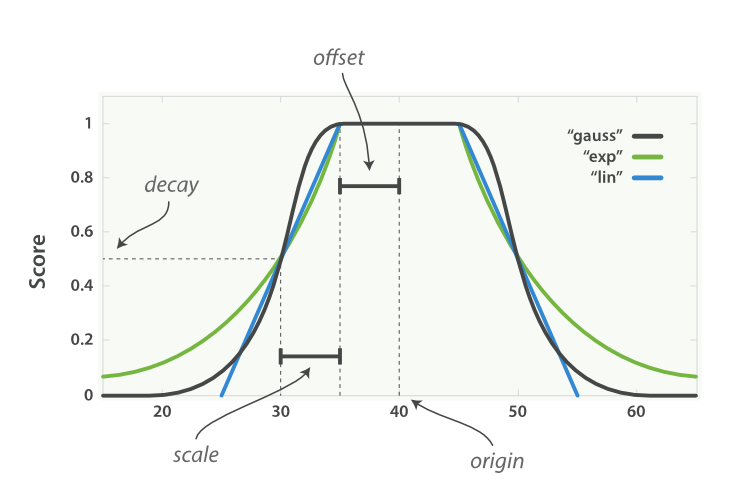

[DEPRECATED] To solve the conflicts, we sobstitute the pair of rows that are one duplicate of the other with a row containing, for each feature, a value that is the mean of the values of the two rows for that feature.

REASON FOR DEPRECATION: performance dropped a lot after duplicated values were taken away with this method (tested and correclty working)

In [50]:
#Function to create a row that represents the mean of two rows, specific to be used for rows with some feature names
def create_mean_row(row1, row2):
    mean_row = row1.copy()
    mean_row['feature_0'] = (row1['feature_0'] + row2['feature_0'])/2
    mean_row['feature_1'] = (row1['feature_1'] + row2['feature_1'])/2
    mean_row['feature_2'] = (row1['feature_2'] + row2['feature_2'])/2
    mean_row['feature_3'] = (row1['feature_3'] + row2['feature_3'])/2
    mean_row['feature_4'] = (row1['feature_4'] + row2['feature_4'])/2
    mean_row['id'] = row1['id']

    return mean_row

In [51]:
#DEPRECATED
def solve_duplicates(df, labels):
    #print('df shape: ' + str(df.shape))
    #print('labels shape: ' + str(labels.shape))
    
    matches = find_matches(df)
    #print('I have ' + str(len(matches)) + ' matches')

    #add id column to both the dataframe and to the labels dataframe
    df['id'] = df.index
    labels['id'] = labels.index

    #create a copy od the dataframe and of the labels dataframe
    final_df = df.copy()
    final_lbs = labels.copy()

    #for each pair of indexes of matching duplicates, create a new row containing as values the mean of the values of the two rows for each feature and use it to sobstitute the two rows
    rows_to_drop = []
    for index in matches.index:
        # Copy the two rows into temporal variables and compute the new row and new label
        row1 = final_df.loc[final_df['id']==index[0]]
        row2 = final_df.loc[final_df['id']==index[1]]
        new_row = create_mean_row(row1, row2)
        new_row['id'] = max(final_df['id']) + 1
        new_label = final_lbs.loc[final_lbs['id']==index[0]]
        new_label['id'] = new_row['id']
        # Add the indexes to the list for later dropping
        rows_to_drop.extend([index[0], index[1]])
        # Append the new label
        final_lbs = pd.concat([final_lbs, new_label], ignore_index=True)
        # Append the new row to the dataframe
        final_df = pd.concat([final_df, new_row], ignore_index=True)
    
    #print('after appending: \n' + 'final_df: ' + str(final_df.shape) + '\nfinal_lbs: ' + str(final_lbs.shape))

    # Drop the rows of duplicates from final_df and final_lbs
    #print('dropping ' + str(len(rows_to_drop)) + ' rows')
    final_df = final_df[~final_df['id'].isin(rows_to_drop)]
    final_lbs = final_lbs[~final_lbs['id'].isin(rows_to_drop)]

    # Drop the id column from final_df and final_lbs
    final_df.drop(columns=['id'], inplace=True)
    final_lbs.drop(columns=['id'], inplace=True)

    #print('final_df: ' + str(final_df.shape))
    #print('final_lbs: ' + str(final_lbs.shape))

    return final_df, final_lbs


To solve the conflicts, we drop the first one of the two rows that are together detected as duplicates

In [52]:
def solve_duplicates_with_dropping(df, labels):
    #print('df shape: ' + str(df.shape))
    #print('labels shape: ' + str(labels.shape))
    
    matches = find_matches(df)
    #print('I have ' + str(len(matches)) + ' matches')

    #add id column to both the dataframe and to the labels dataframe
    df['id'] = df.index
    labels['id'] = labels.index

    #create a copy od the dataframe and of the labels dataframe
    final_df = df.copy()
    final_lbs = labels.copy()

    #for each pair of indexes of matching duplicates, create a new row containing as values the mean of the values of the two rows for each feature and use it to sobstitute the two rows
    rows_to_drop = []
    for index in matches.index:
        # Add the indexes to the list for later dropping
        rows_to_drop.extend([index[0]])

    # Drop the rows of duplicates from final_df and final_lbs
    #print('dropping ' + str(len(rows_to_drop)) + ' rows')
    final_df = final_df[~final_df['id'].isin(rows_to_drop)]
    final_lbs = final_lbs[~final_lbs['id'].isin(rows_to_drop)]

    # Drop the id column from final_df and final_lbs
    final_df.drop(columns=['id'], inplace=True)
    final_lbs.drop(columns=['id'], inplace=True)

    #print('final_df: ' + str(final_df.shape))
    #print('final_lbs: ' + str(final_lbs.shape))

    return final_df, final_lbs

Try with an example:

In [53]:
example = final_datasets_noise_one[1]
labels_example = final_labels_noise_one[1]
df_example = pd.DataFrame(example)
lbs_example = pd.DataFrame(labels_example)

print(df_example.shape)
print(lbs_example.shape)

(1108, 5)
(1108, 1)


In [54]:
df_example.head(5)

0         1         2         3         4
0 -3.044852  0.401225  1.876653  1.566605 -2.132950
1 -0.709783  3.245941  0.338313 -2.530443 -3.607003
2  1.445783  1.330753  1.140285  0.706253  2.422165
3  2.404213  1.620161 -0.710273 -3.793487  1.183956
4  1.573431 -0.558834  0.359672  0.777892  2.637753

In [55]:
#drop exact duplicates
drop_exact(df_example, lbs_example)
print(df_example.shape)
print(lbs_example.shape)

(1108, 5)
(1108, 1)


In [56]:
matches = find_matches(df_example)
print(matches.shape)

(108, 5)


In [57]:
print(df_example.shape)
df_example.head(2)

(1108, 5)


feature_0  feature_1  feature_2  feature_3  feature_4
0  -3.044852   0.401225   1.876653   1.566605  -2.132950
1  -0.709783   3.245941   0.338313  -2.530443  -3.607003

In [58]:
final_df_example, final_lbs_example = solve_duplicates_with_dropping(df_example, lbs_example)
print(final_df_example.shape)
print(final_lbs_example.shape)

(1000, 5)
(1000, 1)


Now down to our experiments:

1) Noising 1 column
2) Rounding 1 column 
3) Noising 2 columns of the same row
4) Rounding 2 columns of the same row
5) Noising 1 column, rounding a different column of the same row
6) Noising and rounding applied together to 2 columns of the same row 
7) Noising 3 different columns of the same row
8) Rounding 3 different columns of the same row
9) Noising 2 columns, rounding a different column of the same row
10) Noising 1 column, rounding 2 different columns of the same row

In [59]:
#convert the list of datasets and labels into dataframes
final_datasets_noise_one_df = []
final_labels_noise_one_df = []
final_datasets_round_one_df = []
final_labels_round_one_df = []
final_datasets_noise_two_df = []
final_labels_noise_two_df = []
final_datasets_round_two_df = []
final_labels_round_two_df = []
final_datasets_noise_round_one_df = []
final_labels_noise_round_one_df = []
final_datasets_round_noise_together_df = []
final_labels_noise_round_together_df = []
final_datasets_noise_three_df = []
final_labels_noise_three_df = []
final_datasets_round_three_df = []
final_labels_round_three_df = []
final_datasets_noise_round_two_one_df = []
final_labels_noise_round_two_one_df = []
final_datasets_noise_round_one_two_df = []
final_labels_noise_round_one_two_df = []

for i in range(10):
    final_datasets_noise_one_df.append(pd.DataFrame(final_datasets_noise_one[i]))
    final_labels_noise_one_df.append(pd.DataFrame(final_labels_noise_one[i]))
    final_datasets_round_one_df.append(pd.DataFrame(final_datasets_round_one[i]))
    final_labels_round_one_df.append(pd.DataFrame(final_labels_round_one[i]))
    final_datasets_noise_two_df.append(pd.DataFrame(final_datasets_noise_two[i]))
    final_labels_noise_two_df.append(pd.DataFrame(final_labels_noise_two[i]))
    final_datasets_round_two_df.append(pd.DataFrame(final_datasets_round_two[i]))
    final_labels_round_two_df.append(pd.DataFrame(final_labels_round_two[i]))
    final_datasets_noise_round_one_df.append(pd.DataFrame(final_datasets_noise_round_one[i]))
    final_labels_noise_round_one_df.append(pd.DataFrame(final_labels_noise_round_one[i]))
    final_datasets_round_noise_together_df.append(pd.DataFrame(final_datasets_round_noise_together[i]))
    final_labels_noise_round_together_df.append(pd.DataFrame(final_labels_noise_round_together[i]))
    final_datasets_noise_three_df.append(pd.DataFrame(final_datasets_noise_three[i]))
    final_labels_noise_three_df.append(pd.DataFrame(final_labels_noise_three[i]))
    final_datasets_round_three_df.append(pd.DataFrame(final_datasets_round_three[i]))
    final_labels_round_three_df.append(pd.DataFrame(final_labels_round_three[i]))
    final_datasets_noise_round_two_one_df.append(pd.DataFrame(final_datasets_noise_round_two_one[i]))
    final_labels_noise_round_two_one_df.append(pd.DataFrame(final_labels_noise_round_two_one[i]))
    final_datasets_noise_round_one_two_df.append(pd.DataFrame(final_datasets_noise_round_one_two[i]))
    final_labels_noise_round_one_two_df.append(pd.DataFrame(final_labels_noise_round_one_two[i]))


In [60]:
#Numpy arrays for results
cleaned_datasets_noise_one = []
cleaned_labels_noise_one = []
cleaned_datasets_round_one = []
cleaned_labels_round_one = []
cleaned_datasets_noise_two = []
cleaned_labels_noise_two = []
cleaned_datasets_round_two = []
cleaned_labels_round_two = []
cleaned_datasets_noise_round_one = []
cleaned_labels_noise_round_one = []
cleaned_datasets_round_noise_together = []
cleaned_labels_noise_round_together = []
cleaned_datasets_noise_three = []
cleaned_labels_noise_three = []
cleaned_datasets_round_three = []
cleaned_labels_round_three = []
cleaned_datasets_noise_round_two_one = []
cleaned_labels_noise_round_two_one = []
cleaned_datasets_noise_round_one_two = []
cleaned_labels_noise_round_one_two = []

In [61]:
#1) Noising 1 column
for i in range(10):
    df = final_datasets_noise_one_df[i]
    labels = final_labels_noise_one_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_noise_one.append(df)
    cleaned_labels_noise_one.append(labels)

#2) Rounding 1 column 
for i in range(10):
    df = final_datasets_round_one_df[i]
    labels = final_labels_round_one_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_round_one.append(df)
    cleaned_labels_round_one.append(labels)

#3) Noising 2 columns of the same row
for i in range(10):
    df = final_datasets_noise_two_df[i]
    labels = final_labels_noise_two_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_noise_two.append(df)
    cleaned_labels_noise_two.append(labels)

#4) Rounding 2 columns of the same row
for i in range(10):
    df = final_datasets_round_two_df[i]
    labels = final_labels_round_two_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_round_two.append(df)
    cleaned_labels_round_two.append(labels)

#5) Noising 1 column, rounding a different column of the same row
for i in range(10):
    df = final_datasets_noise_round_one_df[i]
    labels = final_labels_noise_round_one_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_noise_round_one.append(df)
    cleaned_labels_noise_round_one.append(labels)

#6) Noising and rounding applied together to 2 columns of the same row 
for i in range(10):
    df = final_datasets_round_noise_together_df[i]
    labels = final_labels_noise_round_together_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_round_noise_together.append(df)
    cleaned_labels_noise_round_together.append(labels)

#7) Noising 3 different columns of the same row
for i in range(10):
    df = final_datasets_noise_three_df[i]
    labels = final_labels_noise_three_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_noise_three.append(df)
    cleaned_labels_noise_three.append(labels)

#8) Rounding 3 different columns of the same row
for i in range(10):
    df = final_datasets_round_three_df[i]
    labels = final_labels_round_three_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_round_three.append(df)
    cleaned_labels_round_three.append(labels)

#9) Noising 2 columns, rounding a different column of the same row
for i in range(10):
    df = final_datasets_noise_round_two_one_df[i]
    labels = final_labels_noise_round_two_one_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_noise_round_two_one.append(df)
    cleaned_labels_noise_round_two_one.append(labels)

#10) Noising 1 column, rounding 2 different columns of the same row
for i in range(10):
    df = final_datasets_noise_round_one_two_df[i]
    labels = final_labels_noise_round_one_two_df[i]
    drop_exact(df, labels)
    df, labels = solve_duplicates_with_dropping(df, labels)
    df = df.values
    labels = labels.values
    cleaned_datasets_noise_round_one_two.append(df)
    cleaned_labels_noise_round_one_two.append(labels)


# Duplicates - Data Analysis and Evaluation after Cleaning 

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

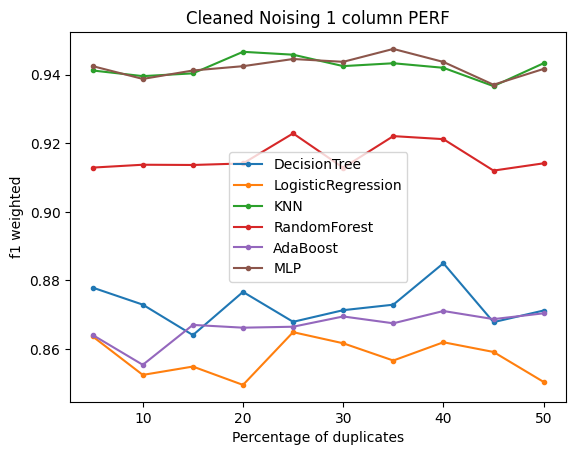

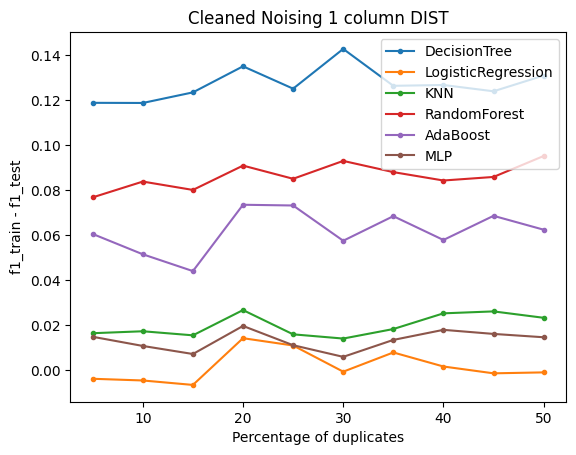

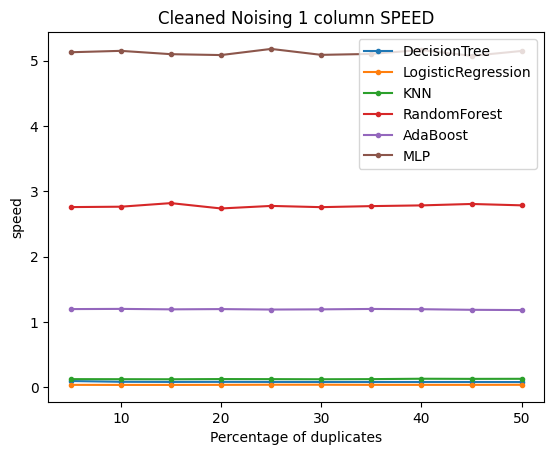

In [62]:
#1) Noising 1 column
classifier_function(cleaned_datasets_noise_one, cleaned_labels_noise_one, "Cleaned Noising 1 column PERF", "Cleaned Noising 1 column DIST", "Cleaned Noising 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

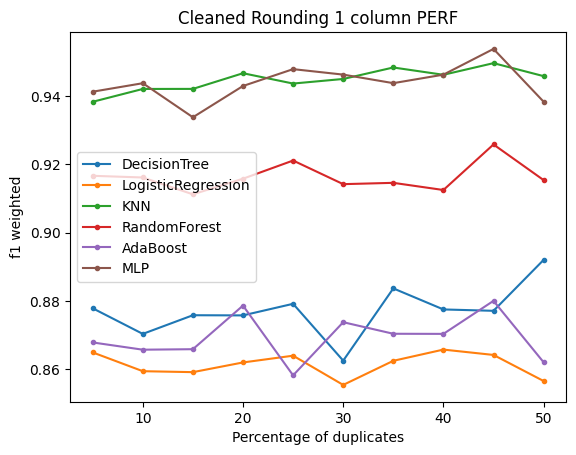

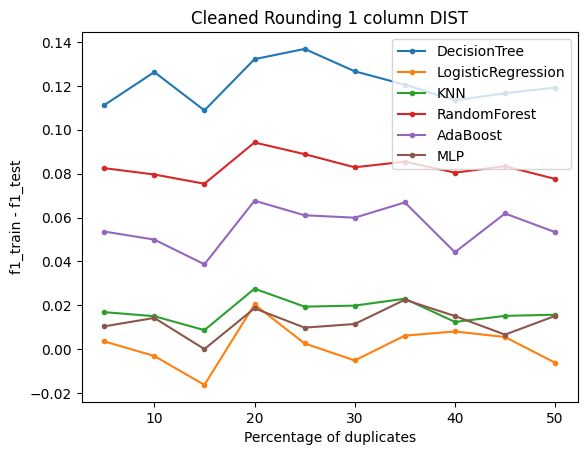

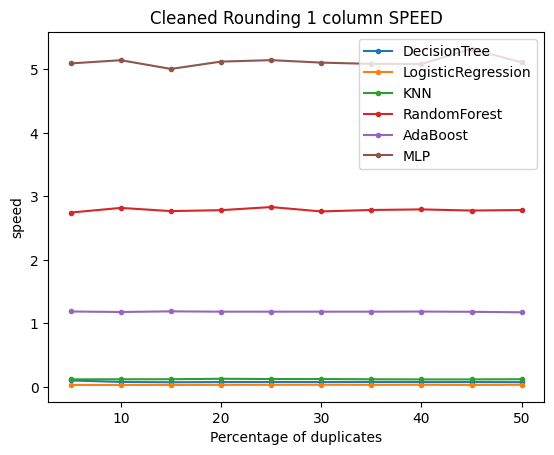

In [63]:
#2) Rounding 1 column 
classifier_function(cleaned_datasets_round_one, cleaned_labels_round_one, "Cleaned Rounding 1 column PERF", "Cleaned Rounding 1 column DIST", "Cleaned Rounding 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

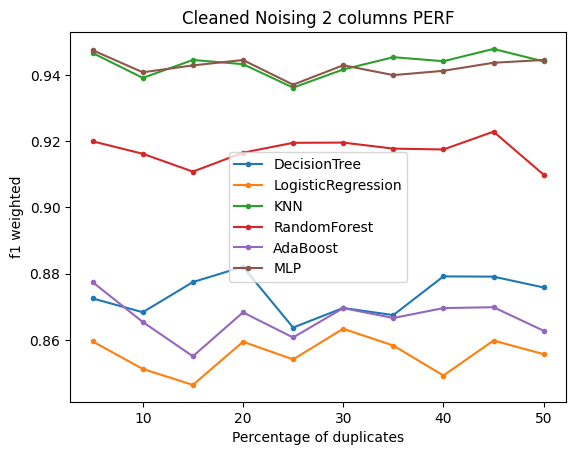

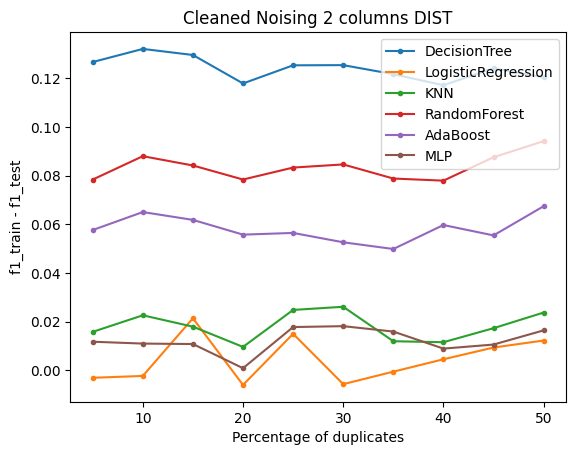

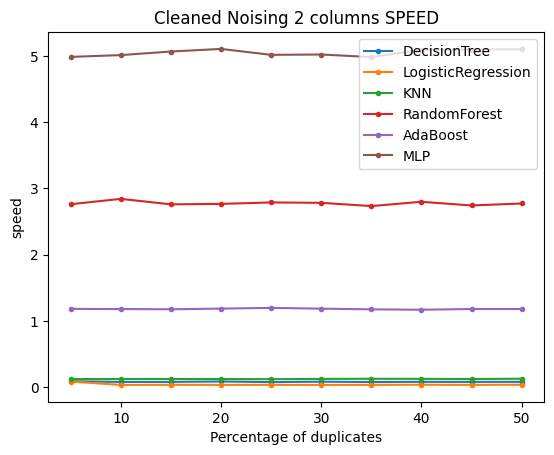

In [64]:
#3) Noising 2 columns of the same row
classifier_function(cleaned_datasets_noise_two, cleaned_labels_noise_two, "Cleaned Noising 2 columns PERF", "Cleaned Noising 2 columns DIST", "Cleaned Noising 2 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

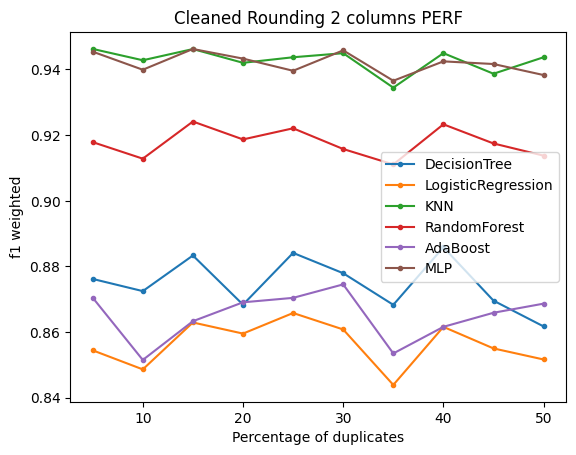

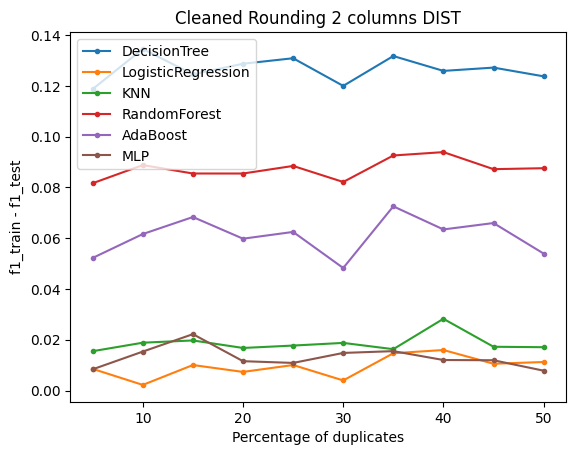

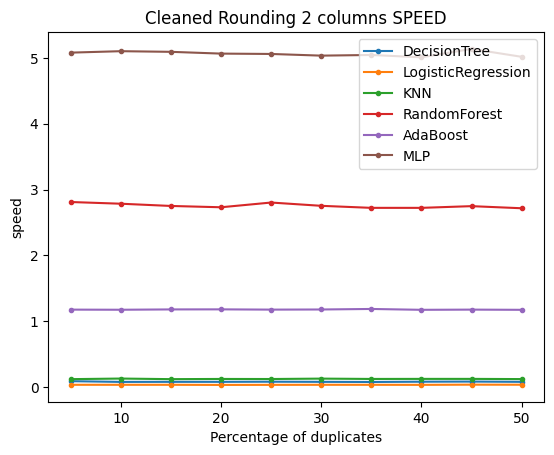

In [65]:
#4) Rounding 2 columns of the same row
classifier_function(cleaned_datasets_round_two, cleaned_labels_round_two, "Cleaned Rounding 2 columns PERF", "Cleaned Rounding 2 columns DIST", "Cleaned Rounding 2 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

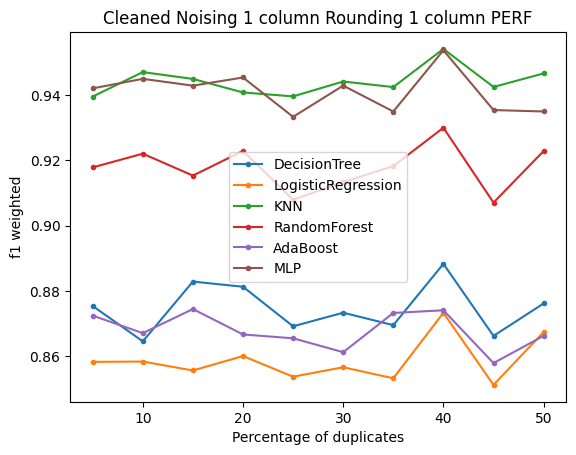

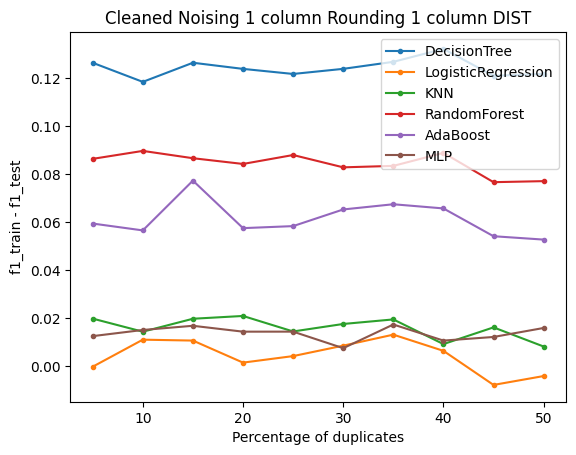

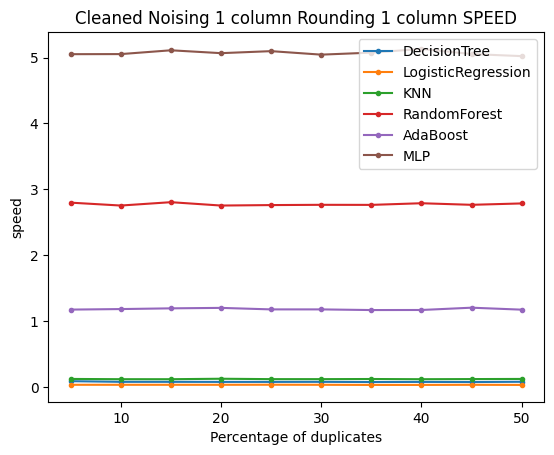

In [66]:
#5) Noising 1 column, rounding a different column of the same row
classifier_function(cleaned_datasets_noise_round_one, cleaned_labels_noise_round_one, "Cleaned Noising 1 column Rounding 1 column PERF", "Cleaned Noising 1 column Rounding 1 column DIST", "Cleaned Noising 1 column Rounding 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

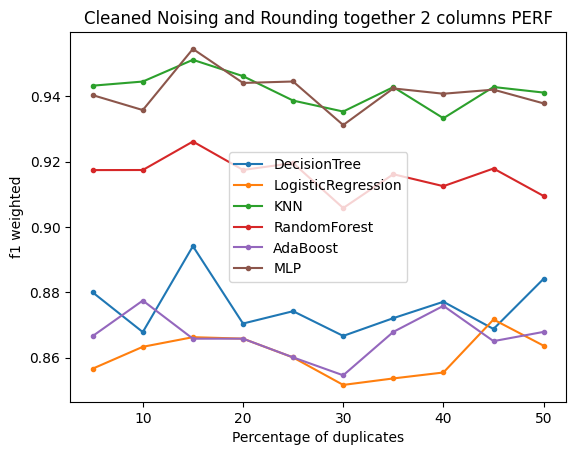

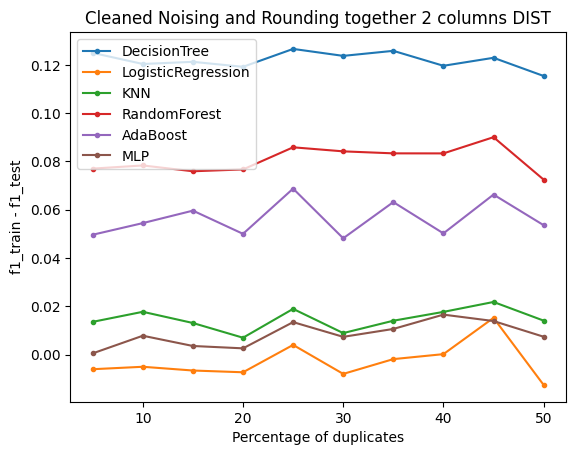

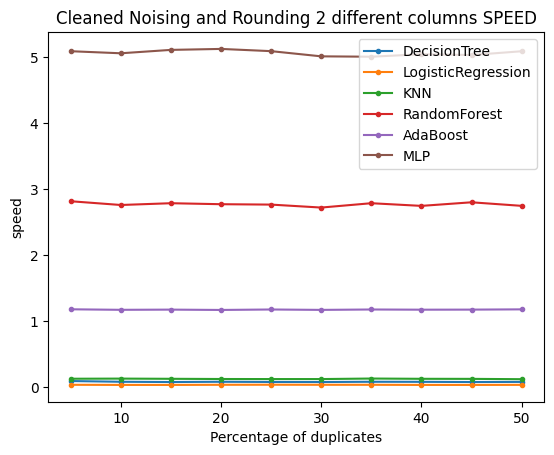

In [67]:
#6) Noising and rounding applied together to 2 columns of the same row 
classifier_function(cleaned_datasets_round_noise_together, cleaned_labels_noise_round_together, "Cleaned Noising and Rounding together 2 columns PERF", "Cleaned Noising and Rounding together 2 columns DIST", "Cleaned Noising and Rounding 2 different columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

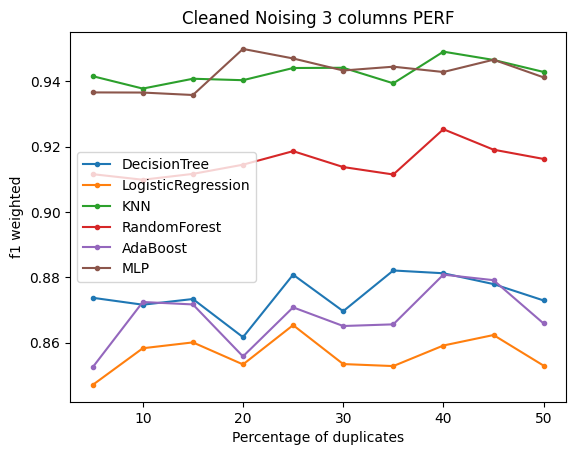

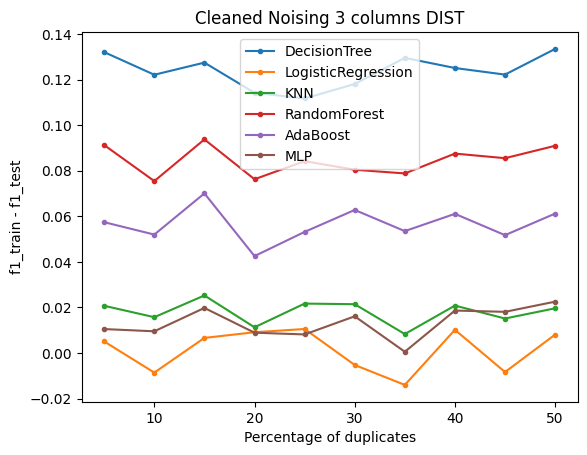

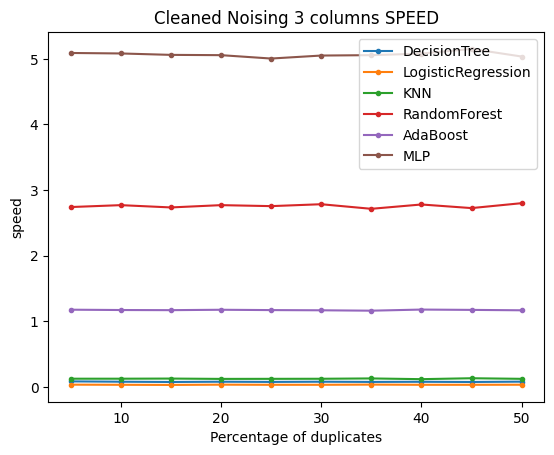

In [68]:
#7) Noising 3 different columns of the same row
classifier_function(cleaned_datasets_noise_three, cleaned_labels_noise_three, "Cleaned Noising 3 columns PERF", "Cleaned Noising 3 columns DIST", "Cleaned Noising 3 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

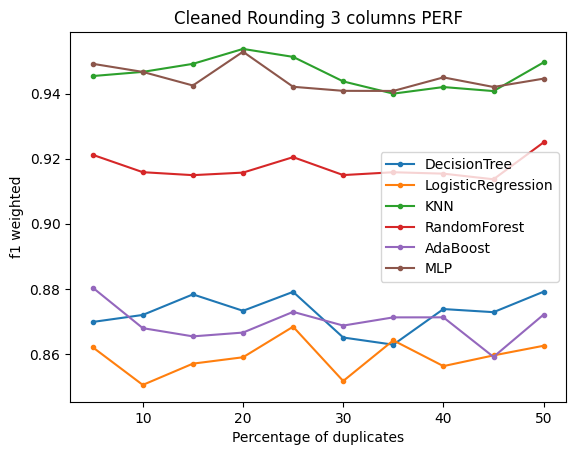

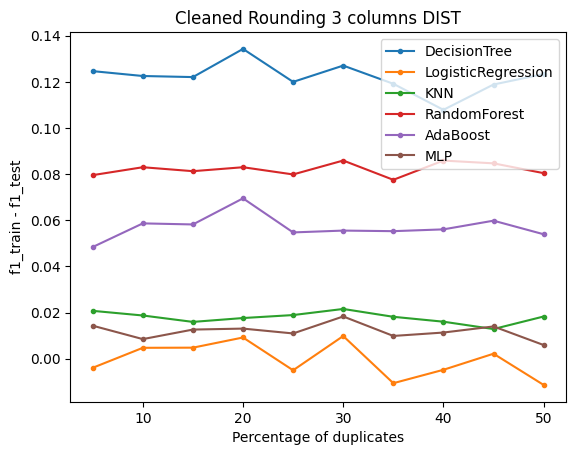

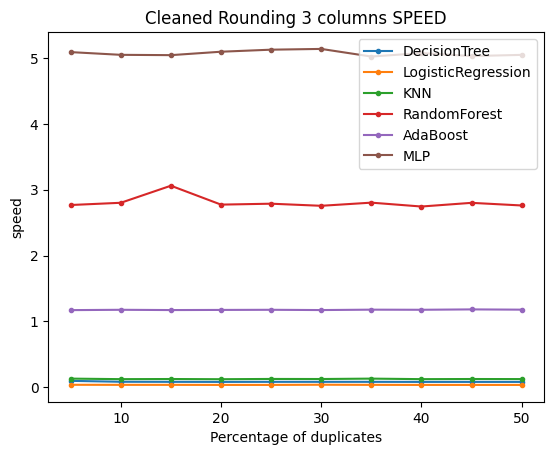

In [69]:
#8) Rounding 3 different columns of the same row
classifier_function(cleaned_datasets_round_three, cleaned_labels_round_three, "Cleaned Rounding 3 columns PERF", "Cleaned Rounding 3 columns DIST", "Cleaned Rounding 3 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

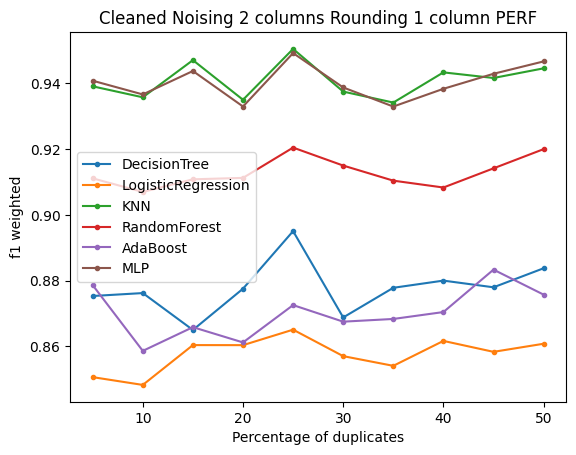

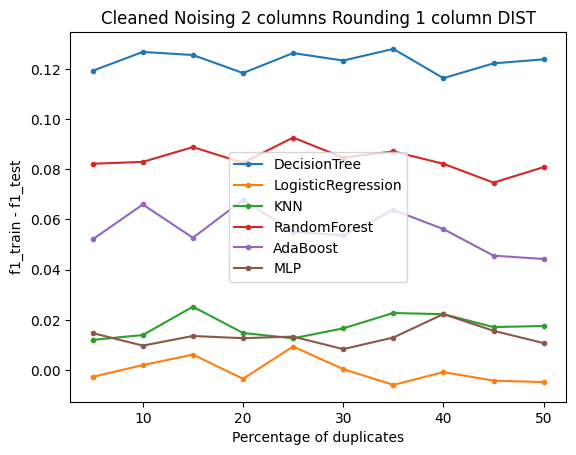

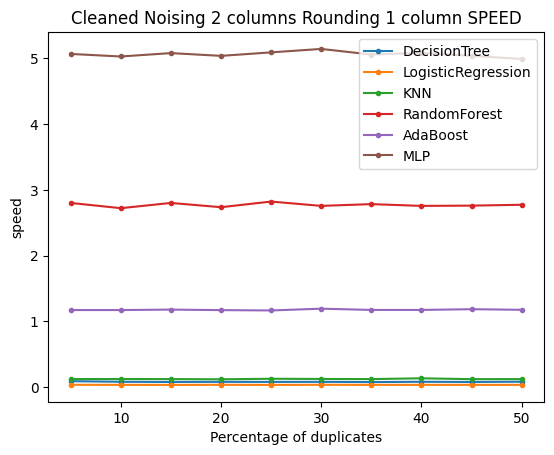

In [70]:
#9) Noising 2 columns, rounding a different column of the same row
classifier_function(cleaned_datasets_noise_round_two_one, cleaned_labels_noise_round_two_one, "Cleaned Noising 2 columns Rounding 1 column PERF", "Cleaned Noising 2 columns Rounding 1 column DIST", "Cleaned Noising 2 columns Rounding 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

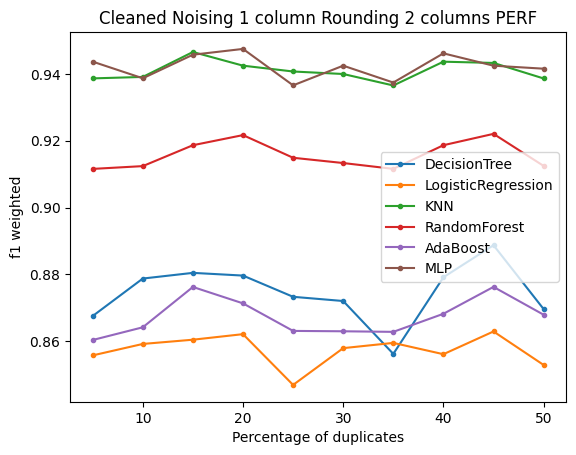

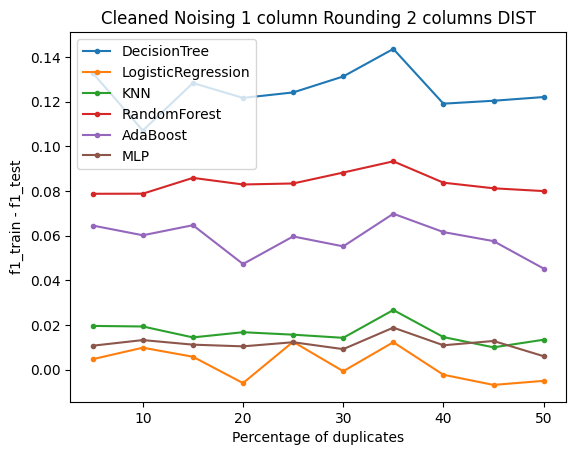

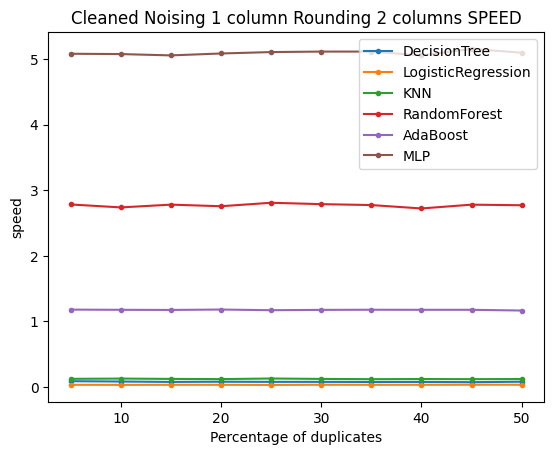

In [71]:
#10) Noising 1 column, rounding 2 different columns of the same row
classifier_function(cleaned_datasets_noise_round_one_two, cleaned_labels_noise_round_one_two, "Cleaned Noising 1 column Rounding 2 columns PERF", "Cleaned Noising 1 column Rounding 2 columns DIST", "Cleaned Noising 1 column Rounding 2 columns SPEED")

# Variable types - Data pollution

Correlation analysis: we want to identify relationships between variables using correlation coefficients

To generate new features, we exploit some dependency that we appositely create between the existing features and the newly generated one that we want to be categorical or boolean

In [170]:
from enum import Enum

#enumerate positive or negative numbers
class Sign(Enum):
    POSITIVE = 1
    NEGATIVE = 2

#Enumerate some colors
class Color(Enum):
    GREEN = 1
    BLUE = 2
    PURPLE = 3
    YELLOW = 4
    ORANGE = 5
    RED = 6


#Enumerate the numbers from 1 to 40
class Number(Enum):
    ONE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8
    NINE = 9
    TEN = 10
    ELEVEN = 11
    TWELVE = 12
    THIRTEEN = 13
    FOURTEEN = 14
    FIFTEEN = 15
    SIXTEEN = 16
    SEVENTEEN = 17
    EIGHTEEN = 18
    NINETEEN = 19
    TWENTY = 20
    TWENTYONE = 21
    TWENTYTWO = 22
    TWENTYTHREE = 23
    TWENTYFOUR = 24
    TWENTYFIVE = 25
    TWENTYSIX = 26
    TWENTYSEVEN = 27
    TWENTYEIGHT = 28
    TWENTYNINE = 29
    THIRTY = 30
    THIRTYONE = 31
    THIRTYTWO = 32
    THIRTYTHREE = 33
    THIRTYFOUR = 34
    THIRTYFIVE = 35
    THIRTYSIX = 36
    THIRTYSEVEN = 37
    THIRTYEIGHT = 38
    THIRTYNINE = 39
    FORTY = 40


First added feature: categorical column with two values

In [171]:
#function to create a new column based on the sum of the columns of the dataframe, assigning enum POS or NEG according to sign
def add_sum_POS_NEG(df):
    df['sum_sign'] = df.iloc[:, 0:4].sum(axis=1).apply(lambda x: Sign.POSITIVE if x > 0 else Sign.NEGATIVE)
    return df

#function to create a new column based on the sum of the columns of the dataframe, assigning TRUE or FALSE according to sign
def add_sum_POS_NEG_bool(df):
    df['sum_sign_positive'] = df.iloc[:, 0:4].sum(axis=1).apply(lambda x: True if x > 0 else False)
    return df


Second added feature: categorical column containing a color based on the value of the median absolute deviation

In [172]:
#funtion to generate a new column with the median absolute deviation of other columns of the dataframe
def add_median_absolute_deviation_column(df):
    df['mad_colors'] = df.iloc[:, 0:4].apply(lambda x: abs(x - x.median()).mean(), axis=1)
    return df


In [174]:
#replace the 'mad' value with a color according to fixed intervals
def mad_to_color(df):
    df['mad_colors'] = df['mad_colors'].apply(lambda x: Color.GREEN if x < 0.5 else Color.BLUE if x < 1.0 else Color.PURPLE if x < 1.5 else Color.YELLOW if x < 2.0 else Color.ORANGE if x < 2.5 else Color.RED)
    return df



In [175]:
def add_mad_colors(df):
    df = add_median_absolute_deviation_column(df)
    df = mad_to_color(df)
    return df

Third added feature: categorical column containing enumeration of number names, assigned according always to the mad but in a variable number and following equally wide intervals that depend on the specified number of intervals

In [176]:
def add_mad_numbers(df, num_intervals, col_name='mad_num'):

    if( num_intervals > 39): return df

    df[col_name] = df.iloc[:, 0:5].apply(lambda x: abs(x - x.median()).mean(), axis=1)
    max = df[col_name].max()
    min = df[col_name].min()
    interval_wide = (max - min)/num_intervals
    #print('max-min: '+str(df.max()['mad_num'] - df.min()['mad_num']))
    #print('interval_wide: '+str(interval_wide))
    
    # Convert Enum to list
    #enum_list = list(Number)
    #for i in range(0, num_intervals):
        #df[col_name] = df[col_name].apply(lambda x: enum_list[i] if ((isinstance(x, float)) and ( min + (interval_wide * i) <= x < min + (interval_wide * (i + 1)) )) else x)

    # Bin the values into intervals
    bins = np.arange(min, max, interval_wide)
    df[col_name] = df[col_name].apply(lambda x: Number(int(np.digitize(x, bins))) if isinstance(x, float) else x)
    
    return df

#df = add_mad_numbers(df, 10)
#df



Test the functions:

In [177]:
df_test = pd.DataFrame(X)

add_sum_POS_NEG(df_test)
add_mad_colors(df_test)
add_mad_numbers(df_test, 10)
df_test

0         1         2         3         4       sum_sign  \
0   -3.044852  0.401225  1.876653  1.566605 -2.132950  Sign.POSITIVE   
1    1.445783  1.330753  1.140285  0.706253  2.422165  Sign.POSITIVE   
2    2.404213  1.620161 -0.710273 -3.793487  1.183956  Sign.NEGATIVE   
3    1.573431 -0.558834  0.359672  0.777892  2.637753  Sign.POSITIVE   
4   -0.849001  2.114740  3.329424 -1.255837 -1.173801  Sign.POSITIVE   
..        ...       ...       ...       ...       ...            ...   
995  0.852847 -0.726076 -2.160768 -3.265680 -0.749785  Sign.NEGATIVE   
996  0.482150  0.830578  0.418977  1.189807  2.350933  Sign.POSITIVE   
997  0.173973 -1.095862  0.148571 -1.312195  1.049151  Sign.NEGATIVE   
998 -1.475855 -0.718746 -2.108539 -1.984390 -2.674930  Sign.NEGATIVE   
999 -1.730336  0.861486  1.964623 -0.612533 -1.514616  Sign.POSITIVE   

       mad_colors       mad_num  
0    Color.YELLOW    Number.SIX  
1     Color.GREEN    Number.ONE  
2    Color.ORANGE    Number.SIX  
3      Color.BLUE  Number.THREE  
4    Color.YELLOW    Number.SIX  
..            ...           ...  
995  Color.PURPLE   Number.FOUR  
996   Color.GREEN    Number.TWO  
997    Color.BLUE  Number.THREE  
998   Color.GREEN    Number.TWO  
999  Color.PURPLE   Number.FOUR  

[1000 rows x 8 columns]

Briefly study the added columns:

In [178]:
#count the occurences of POSITIVE and NEGATIVE
df_test['sum_sign'].value_counts()

sum_sign
Sign.NEGATIVE    542
Sign.POSITIVE    458
Name: count, dtype: int64

<Axes: xlabel='sum_sign'>

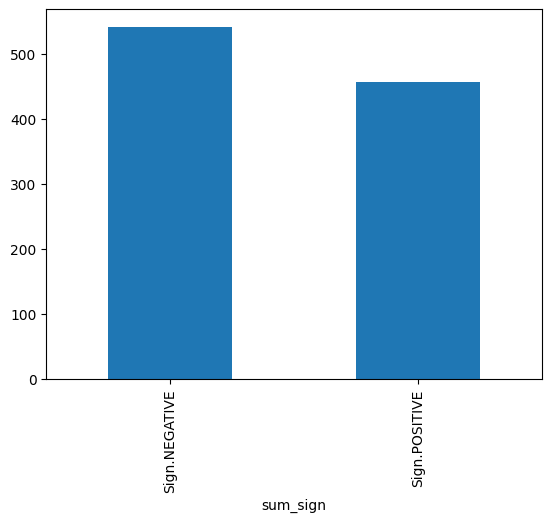

In [179]:
#print a histogram of the value counts in 'sum_sign' column
df_test['sum_sign'].value_counts().plot(kind='bar')

In [180]:
#count the occurences of the mad colors
df_test['mad_colors'].value_counts()

mad_colors
Color.BLUE      431
Color.PURPLE    332
Color.YELLOW    120
Color.GREEN      92
Color.ORANGE     24
Color.RED         1
Name: count, dtype: int64

<Axes: xlabel='mad_colors'>

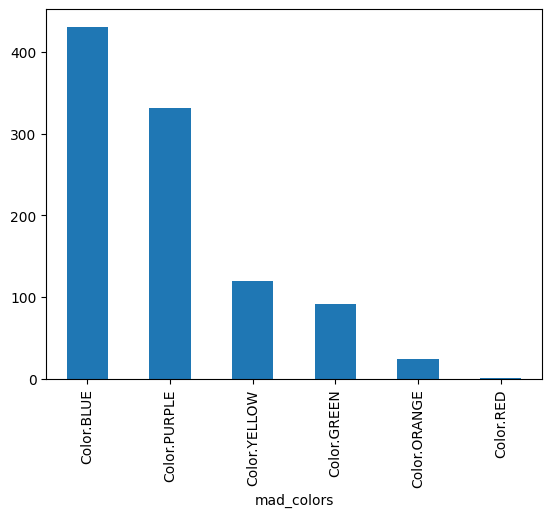

In [181]:
#print a histogram of the value counts in 'mad_colors' column
df_test['mad_colors'].value_counts().plot(kind='bar')

In [182]:
#count the occurences of the mad numbers
df_test['mad_num'].value_counts()

mad_num
Number.THREE    280
Number.FOUR     248
Number.TWO      159
Number.FIVE     143
Number.SIX       73
Number.ONE       36
Number.SEVEN     32
Number.EIGHT     17
Number.NINE       7
Number.TEN        5
Name: count, dtype: int64

<Axes: xlabel='mad_num'>

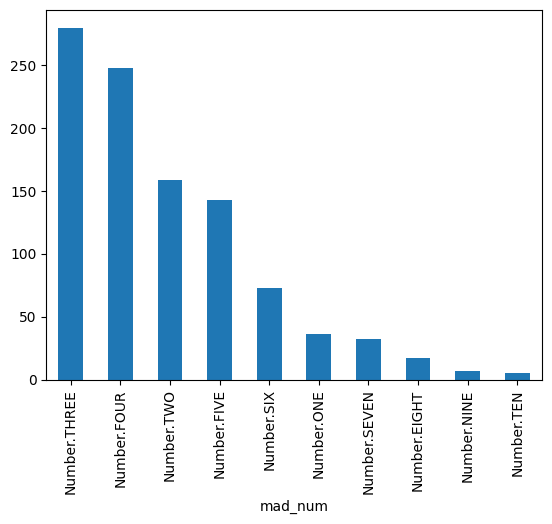

In [183]:
#print a histogram of the value counts in 'mad_num' column
df_test['mad_num'].value_counts().plot(kind='bar')

In [184]:
df_test = pd.DataFrame(X)
add_sum_POS_NEG_bool(df_test)
add_mad_numbers(df_test, 10)

0         1         2         3         4  sum_sign_positive  \
0   -3.044852  0.401225  1.876653  1.566605 -2.132950               True   
1    1.445783  1.330753  1.140285  0.706253  2.422165               True   
2    2.404213  1.620161 -0.710273 -3.793487  1.183956              False   
3    1.573431 -0.558834  0.359672  0.777892  2.637753               True   
4   -0.849001  2.114740  3.329424 -1.255837 -1.173801               True   
..        ...       ...       ...       ...       ...                ...   
995  0.852847 -0.726076 -2.160768 -3.265680 -0.749785              False   
996  0.482150  0.830578  0.418977  1.189807  2.350933               True   
997  0.173973 -1.095862  0.148571 -1.312195  1.049151              False   
998 -1.475855 -0.718746 -2.108539 -1.984390 -2.674930              False   
999 -1.730336  0.861486  1.964623 -0.612533 -1.514616               True   

          mad_num  
0      Number.SIX  
1      Number.ONE  
2      Number.SIX  
3    Number.THREE  
4      Number.SIX  
..            ...  
995   Number.FOUR  
996    Number.TWO  
997  Number.THREE  
998    Number.TWO  
999   Number.FOUR  

[1000 rows x 7 columns]

In [185]:
df_test['sum_sign_positive'].value_counts()

sum_sign_positive
False    542
True     458
Name: count, dtype: int64

In [186]:
df_test['mad_num'].value_counts()

mad_num
Number.THREE    280
Number.FOUR     248
Number.TWO      159
Number.FIVE     143
Number.SIX       73
Number.ONE       36
Number.SEVEN     32
Number.EIGHT     17
Number.NINE       7
Number.TEN        5
Name: count, dtype: int64

Generate datasets for 10 different experiments:

In [187]:
X_vt = []
df_vt = []
y_vt = []

#generate 10 random non-repeated integer seeds
seeds = np.random.choice(10000, 10, replace=False)

#generate 10 datasets for the experiments
for i in range (0,10):
    X_temp, y_temp = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=seeds[i])
    X_vt.append(X_temp)
    df_vt.append(pd.DataFrame(X_temp))
    y_vt.append(y_temp)

    #df_temp = pd.DataFrame(X_vt[i])
    #print(df_temp.head(3))

Pollute the 10 experiments with categorical columns in different measures

In [188]:
for i, df in enumerate(df_vt):
    if i == 0:
        #Ex1: boolean col
        add_sum_POS_NEG_bool(df)
    elif i == 1:
        #Ex2: colors
        add_mad_colors(df)
    elif i == 2:
        #Ex3: numbers 10
        add_mad_numbers(df, 10)
    elif i == 3:
        #Ex4: numbers 30
        add_mad_numbers(df, 30)
    elif i == 4:
        #Ex5: boolean col + sign string
        add_sum_POS_NEG_bool(df)
        add_sum_POS_NEG(df)
    elif i == 5:
        #Ex6: boolean col + numbers 10
        add_sum_POS_NEG_bool(df)
        add_mad_numbers(df, 10)
    elif i == 6:
        #Ex7: colors + numbers 10
        add_mad_colors(df)
        add_mad_numbers(df, 10)
    elif i == 7:
        #Ex8: colors + numbers 30
        add_mad_colors(df)
        add_mad_numbers(df, 30)
    elif i == 8:
        #Ex9: boolean col + colors + numbers 10
        add_sum_POS_NEG_bool(df)
        add_mad_colors(df)
        add_mad_numbers(df, 10)
    elif i == 9:
        #Ex10: boolean col + colors + numbers 10 + numbers 30
        add_sum_POS_NEG_bool(df)
        add_mad_colors(df)
        add_mad_numbers(df, 10)
        add_mad_numbers(df, 30, "mad_num_2")
    else:
        print("error in pollution")

In [189]:
#Examine results
for i, df in enumerate(df_vt):
    print('\ndataset '+str(i)+":")
    print(df.head(3))


dataset 0:
          0         1         2         3         4  sum_sign_positive
0 -3.373088  2.146862 -1.316349 -1.291534 -0.928521              False
1 -0.619575 -1.031034 -1.016641  0.772633 -1.349670              False
2  0.810193  1.921425 -0.879233 -0.798139  1.828286               True

dataset 1:
          0         1         2         3         4    mad_colors
0  1.903488 -1.781324 -1.386642  1.083649 -0.660042  Color.YELLOW
1  2.562821 -0.493411 -1.110368 -3.107188  3.081336  Color.YELLOW
2  1.413726  0.445588 -2.431405  1.605692 -0.401206  Color.PURPLE

dataset 2:
          0         1         2         3         4       mad_num
0  1.297458  2.705159  0.448236  2.844867 -1.568790   Number.FIVE
1  2.666890 -0.291918 -1.618717  1.190944 -0.960964   Number.FIVE
2  0.633156 -2.481788  0.012128  0.411867 -1.083374  Number.THREE

dataset 3:
          0         1         2         3         4          mad_num
0 -1.404912  0.883351  1.090220 -1.942863  1.893273  Number.THIRTEEN
1 

# Variable types - data anlysis and evaluation

ML algorithms require numerical input, so we firstly encode categorical variables to convert qualitative attributes into numerical values.

In [190]:
#Encoding of categorical variables
for i in range(0,10):
    df_vt[i] = encoding_categorical_variables(df_vt[i])

In [191]:
#To see how the encoding went
for i, df in enumerate(df_vt):
    print('\ndataset '+str(i)+":")
    print(df.head(3))


dataset 0:
          0         1         2         3         4
0 -3.373088  2.146862 -1.316349 -1.291534 -0.928521
1 -0.619575 -1.031034 -1.016641  0.772633 -1.349670
2  0.810193  1.921425 -0.879233 -0.798139  1.828286

dataset 1:
          0         1         2         3         4  mad_colors_Color.YELLOW  \
0  1.903488 -1.781324 -1.386642  1.083649 -0.660042                     True   
1  2.562821 -0.493411 -1.110368 -3.107188  3.081336                     True   
2  1.413726  0.445588 -2.431405  1.605692 -0.401206                    False   

   mad_colors_Color.PURPLE  mad_colors_Color.BLUE  mad_colors_Color.GREEN  \
0                    False                  False                   False   
1                    False                  False                   False   
2                     True                  False                   False   

   mad_colors_Color.ORANGE  mad_colors_Color.RED  mad_colors_nan  
0                    False                 False           False  
1   

In [192]:
#convert dataframe back to numpy.ndarray
X_vt_polluted = [df.to_numpy() for df in df_vt]

In [193]:
#print X_vt[0]
print(X_vt_polluted[0])

[[-3.37308841  2.14686214 -1.31634882 -1.29153446 -0.92852069]
 [-0.61957532 -1.03103355 -1.01664101  0.77263279 -1.34966987]
 [ 0.81019349  1.92142502 -0.87923319 -0.79813879  1.82828593]
 ...
 [-0.85927321 -0.41785013  0.24668963  1.30634941 -0.43837489]
 [-1.46383904 -2.28132151 -0.63121554  2.24547018  0.20607404]
 [-0.83208285 -0.16389329  0.56181995  1.01567018  0.02662798]]


Actual results collection:

In [194]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree","LogisticRegression","KNN","RandomForest","AdaBoost","MLP"]

results_for_each_algorithm = []
SEED = 2023

for algorithm in CLASSIFICATION_ALGORITHMS:

    results_single_algorithm = []
    for i in range(0, 10):
        results_1_analysis = classification(X_vt_polluted[i], y_vt[i], algorithm, SEED)
        results_single_algorithm.append(results_1_analysis)
    results_for_each_algorithm.append(results_single_algorithm)

Training for DecisionTree...
Training for DecisionTree...


Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...


In [ ]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_for_each_algorithm)

[   [   {   'distance': 0.15174164433274606,
            'mean_perf': 0.8437648162026449,
            'speed': 0.08175444602966309},
        {   'distance': 0.1691607591621591,
            'mean_perf': 0.8387906922921764,
            'speed': 0.08479094505310059},
        {   'distance': 0.15496479276832698,
            'mean_perf': 0.8503170555902317,
            'speed': 0.09257197380065918},
        {   'distance': 0.09122535524842551,
            'mean_perf': 0.9082933014743859,
            'speed': 0.08776640892028809},
        {   'distance': 0.13089130217572126,
            'mean_perf': 0.8637316419633511,
            'speed': 0.07080984115600586},
        {   'distance': 0.17916722096794568,
            'mean_perf': 0.8161556760551227,
            'speed': 0.09078860282897949},
        {   'distance': 0.09534531684949422,
            'mean_perf': 0.8966655052601384,
            'speed': 0.08576607704162598},
        {   'distance': 0.1704507392937064,
            'mean_perf': 0

PLOT THE RESULTS:

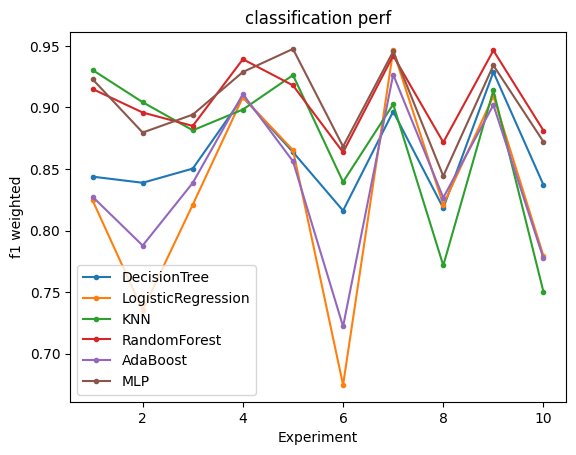

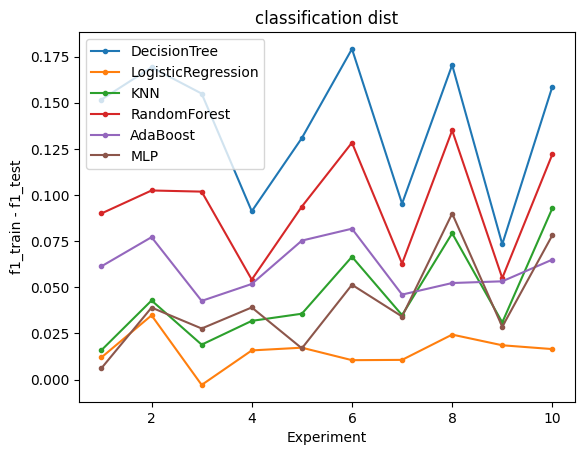

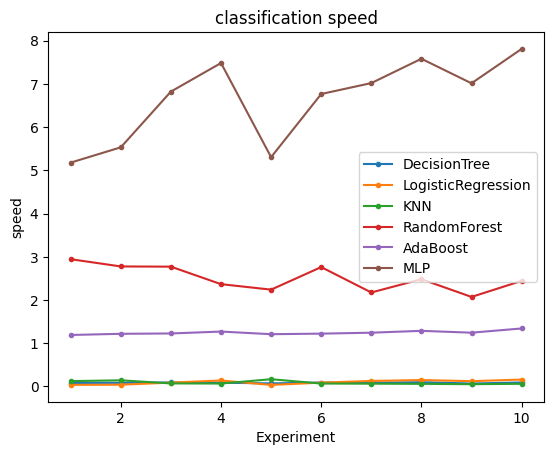

In [ ]:
#plot(x_axis_values=['1: Bool', '2: Colors', '3: Numbers to 10', '4: Numbers to 30', '5: Bool + Sign', '6: Bool + Numbers to 10', '7: Colors + Numbers to 10', '8: Colors + Numbers to 30', '9: Bool + Colors + Numbers to 10', '10: Bool + Colors + Numbers to 10 + Numbers to 30'], x_label="Experiment", results=results_for_each_algorithm, title="classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
#plot(x_axis_values=['1: Bool', '2: Colors', '3: Numbers to 10', '4: Numbers to 30', '5: Bool + Sign', '6: Bool + Numbers to 10', '7: Colors + Numbers to 10', '8: Colors + Numbers to 30', '9: Bool + Colors + Numbers to 10', '10: Bool + Colors + Numbers to 10 + Numbers to 30'], x_label="Experiment", results=results_for_each_algorithm, title="classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
#plot(x_axis_values=['1: Bool', '2: Colors', '3: Numbers to 10', '4: Numbers to 30', '5: Bool + Sign', '6: Bool + Numbers to 10', '7: Colors + Numbers to 10', '8: Colors + Numbers to 30', '9: Bool + Colors + Numbers to 10', '10: Bool + Colors + Numbers to 10 + Numbers to 30'], x_label="Experiment", results=results_for_each_algorithm, title="classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

plot(x_axis_values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], x_label="Experiment", results=results_for_each_algorithm, title="classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], x_label="Experiment", results=results_for_each_algorithm, title="classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], x_label="Experiment", results=results_for_each_algorithm, title="classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")